<a href="https://colab.research.google.com/github/lvb86/PD_LSTM_GA/blob/main/RS_2013_2019_genetico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Algoritimo Genético Para Sintonia de LSTM

Aplicado a Scenário RS 

##Declarações Globais

In [3]:
!pip install -U scikit-learn 

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [4]:
import matplotlib.pyplot        as plt
import matplotlib.ticker        as ticker
import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import tensorflow               as tf
import os
import glob
import shutil
import random                   as rn
import math

from datetime                   import datetime, timedelta
from sklearn.model_selection    import train_test_split,RepeatedStratifiedKFold 
from sklearn.preprocessing      import MinMaxScaler
from sklearn.preprocessing      import StandardScaler        #Normalização dos dados
from sklearn.pipeline           import make_pipeline         #Pipe Line
from sklearn.neural_network     import MLPRegressor
from sklearn.metrics            import mean_absolute_percentage_error

from sklearn.model_selection    import GridSearchCV
#from sklearn.svm import SVC
from tensorflow                 import keras
from tensorflow.keras           import Sequential, layers, callbacks
from tensorflow.keras           import backend as K
from tensorflow.keras.layers    import Dense, LSTM, Dropout, Bidirectional

seed = 170696
sns.set()
sns.set_theme()

#### Path

In [5]:
#path  = '/tmp/'
path  = '/content/drive/MyDrive/Ensino/UFRGS/Projeto de Diplomação/'
patha = path  + 'arcaRS/'
pathb = patha + 'bkp/'
urla  = patha + 'arca.csv'

#urld  = path  + 'RS_2013_2018_df_consumo_clima.csv'
urld  = '/tmp/RS_2013_2018_df_consumo_clima.csv'
#urldfCC = 'https://raw.githubusercontent.com/lvb86/PD_LSTM_GA/709c13dba1d73d5e2964aa4ac28be98aaf99c57c/swap/RS_2013_2018_df_consumo_clima.csv?token=AQEFV3HWW2BY4X3X6DSSOYLA5TOUK'
#urldfCC = 'https://raw.githubusercontent.com/lvb86/PD_LSTM_GA/main/swap/RS_2013_2018_df_consumo_clima.csv'

### Randon Freeze

In [6]:
def imports():
    import matplotlib.pyplot        as plt
    import matplotlib.ticker        as ticker
    import numpy                    as np
    import pandas                   as pd
    import seaborn                  as sns
    import tensorflow               as tf
    import os
    import glob
    import shutil
    import random                   as rn
    import math

    from datetime                   import datetime, timedelta
    from sklearn.model_selection    import train_test_split,RepeatedStratifiedKFold 
    from sklearn.preprocessing      import MinMaxScaler
    from sklearn.preprocessing      import StandardScaler        #Normalização dos dados
    from sklearn.pipeline           import make_pipeline         #Pipe Line
    from sklearn.neural_network     import MLPRegressor
    from sklearn.metrics            import mean_absolute_percentage_error

    from sklearn.model_selection    import GridSearchCV
    #from sklearn.svm import SVC
    from tensorflow                 import keras
    from tensorflow.keras           import Sequential, layers, callbacks
    from tensorflow.keras           import backend as K
    from tensorflow.keras.layers    import Dense, LSTM, Dropout, Bidirectional

    seed = 170696
    sns.set()
    sns.set_theme()

In [7]:
# Utilizando o essa foi a unica maneira encontrada para congelar o randon e 
# garantir a reprodutibilidade do modelo 

def reset_seed(seed,keras=False):
    imports()
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    rn.seed(seed)

    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.compat.v1.set_random_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

def set_seed_rand():
    
    from datetime import datetime

    dt_seg_now = datetime.now().strftime("%S")
    #print("\t\tSEED =", dt_seg_now)	
    nseed = int(dt_seg_now)
    os.environ['PYTHONHASHSEED'] = str(nseed)
    np.random.seed(nseed)
    rn.seed(nseed)
    print("\t\tSEED =", dt_seg_now)	


## Dados

In [8]:
df = pd.read_csv(urld, index_col=0)
df['mes_sin'] = np.sin(df['Mês']*2*np.pi/12)
df['mes_cos'] = np.cos(df['Mês']*2*np.pi/12)
d = df.drop(columns=['Ano Mês', 'Mês', 'Consumo Médio', 'Rlin' ]).reset_index()
Ycolumns = ['Consumo', 'Comercial', 'Consumo Próprio', 'Iluminação Pública',
            'Industrial', 'Poder Público', 'Residencial', 'Rural',
            'Serviço Público']
Xcolumns = [*{*d.columns.to_list()}-{*Ycolumns}]

print('X\n',len(Xcolumns),'\n', Xcolumns)
print('Y\n',len(Ycolumns),'\n', Ycolumns)

X
 9 
 ['mes_cos', 'Pressão', 'Precipitação', 'Vento Máx', 'Ano', 'Dias com Precipitação', 'mes_sin', 'Temperatura', 'Vento Méd']
Y
 9 
 ['Consumo', 'Comercial', 'Consumo Próprio', 'Iluminação Pública', 'Industrial', 'Poder Público', 'Residencial', 'Rural', 'Serviço Público']


In [9]:
X = d[Xcolumns]
y = d[Ycolumns]
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X)
#output_scaler = scaler_y.fit(y.to_numpy().reshape(-1,1))
output_scaler = scaler_y.fit(y)

# Apply the scaler to training data
X_norm = input_scaler.transform(X)
#y_norm = output_scaler.transform(y.to_numpy().reshape(-1,1))
y_norm = output_scaler.transform(y)

X_train = X_norm[:60]
y_train = y_norm[:60]

X_test = X_norm[60:]
y_test = y_norm[60:]

y_real = y[60:]

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Dimensões X: ",'X_train',X_train.shape,'X_test', X_test.shape)
print("Dimensões Y: ",'Y_train',y_train.shape,'Y_test', y_test.shape)

shape_in = X_train.shape[2]
shape_out = y_train.shape[1]

Dimensões X:  X_train (60, 1, 9) X_test (12, 1, 9)
Dimensões Y:  Y_train (60, 9) Y_test (12, 9)


## Funções

###Genéticas

#### Inicia Populacão

In [10]:
def inicializa_populacao(pop_tamanho, n_genes, limites):
    """
    Inicializa a população de acordo com o tamanho da população
    e número de genes.

    param pop_tamanho:     Número de individuos na população
    param n_genes:         Número de genes (Variáveis) no problema
    param limites:         Tupla contendo o número mínimo e máximo permitido  
    return:                Um array numpy com a população iniciada 
                           randomicamente
    """

    pop0 = np.random.randint(
      limites[0], limites[1], size=(pop_tamanho, n_genes)
    )
    pop=[]
    for e, i in enumerate(pop0):
        if np.sum(i) == 0:
            n = np.random.randint(limites[0]+1, limites[1], size=(1, n_genes))
            #print(e,i,n)
            pop.append(n)
        else:    
            pop.append(i)
    return pop

####Função de aptidão

In [11]:
def rede_desc(bl_list, unit_list, drop_list):
    '''
    Retorna descrição gráfica da Rede

    '''
    dic_bl = {0: 'LSTM', 1:'BILSTM'}
    desc = '->'
    for e,i in enumerate(unit_list):
        if i >0:
            if e < 2:
                desc+=(f'{dic_bl[bl_list[e]]}')   
            else:
                desc+=('MLP')
            desc+=(f'({unit_list[e]})->')
            if e < 5:
                desc+=(f'd({drop_list[e]})->')
    return desc

In [12]:
def decode_gen(chave):
    '''
    Recebe chave genética e retorna estrutura da rede 
    considerando arquitetura predefinida 

            Tipo---\ Dropout -----------------\ Neurônios-------------------\ 
            B|L  B|L  D12  D23  D34  D45  D56  NL1  NL2  NL3  NL4  NL5  NL6              
    chave =[ p01, p02, p03, p04, p05, p06, p07, p07, p08, p09, p10, p11, p12]
            2|1  2|1  2|1  2|1  2|1

    Tipo      -> se par BILSTM se não LSTM
    Dropout   -> If 0 = 0 
                Else
                    Se par 0.2 senão 0.1 
    Neurônios -> If 0 desetiva layer e dropout seguinte 
                Else numero de neurônios da camada                
    '''

    bl_list = []
    drop_list = []
    unit_list = []
    Lini = 0
    Lcount = 0

    for i in range(7,13):
        if chave[i] >0:
            ini = i-6
            break
    for i in range(7,13):
        if chave[i] >0:
            Lcount +=1
    print(f'\tN Layers = {Lcount}')

    for i in range(2):
        if chave[i] % 2 == 0:
            bl_list.append(1)
        else:
            bl_list.append(0)

    for i in range(2,7):
        if chave[i] ==0:
            drop_list.append(0)
        else:
            if chave[i] % 2 == 0:
                drop_list.append(0.2)
            else: 

                drop_list.append(0.1)

    for i in range(7,13):
        unit_list.append(chave[i])

    desc = rede_desc(bl_list, unit_list, drop_list)
    print('\t'+desc)
    return bl_list, unit_list, drop_list, desc

In [13]:
def monta_modelo(bl_list, unit_list, drop_list):
    '''
    Modelo Keras
    '''
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(1,shape_in)))

    for e,i in enumerate(unit_list):
        if i > 0:
            if e < 2:           # LSTM
                if bl_list[e]:
                    model.add(tf.keras.layers.Bidirectional(LSTM (units = i, return_sequences=True )))    
                else:
                    model.add(tf.keras.layers.LSTM(units = i, return_sequences=True ))

            else:               #MLP
                model.add(tf.keras.layers.Dense(units = i, activation=tf.nn.relu) )
            if e < 5:
                                #Dropout
                model.add(tf.keras.layers.Dropout(drop_list[e], seed = seed) )
    model.add(tf.keras.layers.Dense(shape_out))
    
    return model

In [14]:
def func_aptidao(individual):
    """
    Calcula a aptidão de cada individuo

    :param individual:   Cromosomo de genes representando um individuo
    :return:             A aptidão individual e MAPE
    """
    reset_seed(seed)    #Para Garantir a repetibilidae do modelo

    bl_list, unit_list, drop_list, desc = decode_gen(individual)
    model = monta_modelo(bl_list, unit_list, drop_list)
        
    with tf.device(':CPU:0'):

        model.compile(optimizer = 'adam',loss='mse', metrics=['accuracy','mape'])
        early_stop = keras.callbacks.EarlyStopping(monitor = 'loss',
                                            patience = 10)
        model.fit(  x=X_train,
                    y=y_train,
                    batch_size=None,
                    epochs=10000,
                    verbose=False,
                    callbacks=[early_stop],
                    validation_split=0.0,
                    validation_data=(X_test,y_test),
                    shuffle=False,
                    class_weight=None,
                    sample_weight=None,
                    initial_epoch=0,
                    steps_per_epoch=19,
                    validation_steps=1,
                    validation_batch_size=None,
                    validation_freq=1,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False)
        y_pred_norm = model.predict(X_test)

        if shape_out ==1:
            y_pred = output_scaler.inverse_transform(y_pred_norm.ravel().reshape(-1, 1))
        else:
            y_pred = output_scaler.inverse_transform(y_pred_norm.reshape(12,shape_out))

        mape = mean_absolute_percentage_error(y_real,y_pred)
        apti = 1-mape

    print('\t\t','mape','|',mape, '||', 'aptidão','|',apti)
    set_seed_rand()
    yp = y_pred.reshape(12,shape_out)
    return mape, apti, yp

In [15]:
def func_aptidao_old(individual):
    """
    Calcula a aptidão de cada individuo

    :param individual:   Cromosomo de genes representando um individuo
    :return:             A aptidão individual e MAPE
    """
    reset_seed(seed)    #Para Garantir a repetibilidae do modelo

    bl_list, unit_list, drop_list, desc = decode_gen(individual)
    model = monta_modelo(bl_list, unit_list, drop_list)
    
        
    with tf.device(':CPU:0'):

        model.compile(optimizer = 'adam',loss='mse', metrics=['accuracy','mape'])
        early_stop = keras.callbacks.EarlyStopping(monitor = 'loss',
                                            patience = 10)
        model.fit(  x=X_train,
                    y=y_train,
                    batch_size=None,
                    epochs=10000,
                    verbose=False,
                    callbacks=[early_stop],
                    validation_split=0.0,
                    validation_data=(X_test,y_test),
                    shuffle=False,
                    class_weight=None,
                    sample_weight=None,
                    initial_epoch=0,
                    steps_per_epoch=19,
                    validation_steps=1,
                    validation_batch_size=None,
                    validation_freq=1,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False)

        y_pred_norm = model.predict(X_test)
        y_pred = output_scaler.inverse_transform(y_pred_norm.ravel().reshape(-1, 1))
        mape = mean_absolute_percentage_error(y[60:],y_pred.ravel())
        apti = 1-mape

    print('\t\t','mape','|',mape, '||', 'aptidão','|',apti)
    set_seed_rand()
    return mape, apti

#### Seleção de Progenitores

In [16]:
def selecao_de_progenitores(individuos, probabilidades, pares):
    """
    Seleciona os pais de acordo com a estratégia "roulette_wheel" que seleciona 
    individuos aleatoriamente utilizando a maior aptidão como maior 
    probabilidade 
    
    param individuos:       Numero de individuos
    param probabilidades:  distribuíção de probabilidade
    return:                pares escolhidos aleatoriamente
    """
    from math import ceil
    n = len(individuos)
    pares = int(pares)
    if pares*2 > n:
        pares = n/2
    
    p1, p2 = None, None
    pn = np.random.choice(range(n),2*pares, replace = False,p=probabilidades)
    pr = np.random.choice(pn,len(pn),replace=False)
    pp = np.array(pr).reshape(ceil(len(pn)/2),2)

    print('\t\t',pp)   
    return pp

#### Cruzamento

In [17]:
def cruzamento(casal, populacao, ng):
    '''
    param casal:     index tupla (p1,p2) do casal que ira cruzar
    param populacao: recebe a popopulação atual 

    return:          2 filhos com os cruzamentos aleatórios dos genes 
    '''
    p1 = casal[0]   #progenitor 1
    p2 = casal[1]   #progenitor 2
    f1 = []         #filho 1
    f2 = []         #filho 2
    ng = populacao[p1].shape[0]

    print('\t\tpar --', casal,'------')
    print('\t\tp:',p1,populacao[p1]) #p1
    print('\t\tp:',p2,populacao[p2]) #p2

    s1=np.ones(ng)
    while(s1.sum()==ng or s1.sum()==0):   # garantia de que havera ao menos 
        s1=np.random.choice([0,1],ng)    # 1 cruzamento
    print('\t\txxx ', s1)
    for i, b in enumerate(s1):
        #print(i,b)
        if b:
            #print(x[7][i])
            f1.append(populacao[p1][i])
            f2.append(populacao[p2][i])
        else:
            #print(x[9][i])
            f1.append(populacao[p2][i])
            f2.append(populacao[p1][i])
    print('\t\tf1  ',f1)
    print('\t\tf2  ',f2)
    return np.array(f1),np.array(f2)

#### Mutação

In [18]:
#mutacao
def mutacao(original, proba_mut, ng):
    '''
    apartir de um individuo original será gerado 1 individuo mutante
    
    param original:     cromossomo do individuo original
    param proba_mut:    probabilidade de mutação 
    return:             mutante
    '''
    mutante = [] 
    print('\t\tori ', original)
    
    gm = np.random.choice(64,ng)    #Sequencia mutante Aleatória

    s1=np.ones(ng)
    while(s1.sum()==0):   # garantia de que havera ao menos 
        s1=np.random.choice([0,1],ng,p=[1-proba_mut,proba_mut])    # 1 mutação
    print('\t\txxx ', s1)
    for i, b in enumerate(s1):
        #print(i,b)
        if b:
            #print(x[7][i])
            mutante.append(gm[i])
            
        else:
            mutante.append(original[i])
            
    print('\t\tmut ',mutante)

    return  np.array(mutante)

###Busca e Salvamento 

In [19]:
def busca_item_lista(_item, _lista):
    '''
    Percorre a lista de arrays e retorna a posição se encontrar ou false se 
    não enontrar 
    
    '''
    for index, it in enumerate(_lista): 

        #print(index,it,_item, all(it==_item))
        if (all(it==_item)):
            return True, index
    return False, False

In [20]:
def salva_arca(_ep,idtest):
    now = datetime.now().strftime('_%y_%m_%d-%H_%M_')
    url = patha + 'arca' +str(idtest)+ now + str(_ep) + '.csv'
    #arca = pd.DataFrame([arca_gen,arca_mape,arca_apt]).T
    arca = pd.DataFrame(dic_arca).T.iloc[:,-3:]   
    arca.columns = ['gen','mape','apt']
    arca.apt = 1-arca.mape  #correção de aptidão relativa para geral
    arca.to_csv(url,index=False)

In [21]:
def recupera_arca():
    '''
    Recupera dados de testes passados
    
    return: arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i
    '''
    url = patha + 'arca.csv'
    arca_gen_str = pd.read_csv(url).gen.to_list()
    arca_mape    = pd.read_csv(url).mape.to_list()
    arca_apt     = pd.read_csv(url).apt.to_list()

    arca_gen = []
    for e, arc_g in enumerate(arca_gen_str):
        arca_gen.append(gene_str2numpy(arc_g))
    print(len(arca_gen))
    dic_arca = {} # Cria dicionário vazio. # set() = conjunto vazio
    dic_arca_i = {} 
    for e, i in enumerate(arca_gen):
        dic_arca[tuple(i)] = [e,i,arca_mape[e],arca_apt[e]]
        dic_arca_i[e] = i    

    return arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i

In [22]:
#arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i = recupera_arca()

In [23]:
#len(arca_gen) == len(arca_mape)

In [24]:
def gene_str2numpy(_str): 
    '''

    return: np.array com a sequencialida 
    '''
    indice = []
    arn = [] 
    ultimo = 9999
    for i, c in enumerate(_str):
        if ord(c) in (91,32,93):
            if i != ultimo + 1:
                indice.append(i)
            # print(i,c,ord(c),)
                ultimo = i

    for i in range(len(indice)-1):
        n_str =_str[indice[i]+1:indice[i+1]]
        arn.append(int(n_str.strip()))
    return np.array(arn)

In [25]:
def salva_resultado(_ep,_res,_mut,_tempo,_pop,_pop_r,_pop_c,idtest):
    now = datetime.now().strftime('_%y_%m_%d-%H_%M_')
    url = path + 'resultado' +str(idtest)+ now + str(_ep) + '.csv'
    result = pd.DataFrame([_res,_mut,_tempo,_pop,_pop_r,_pop_c]).T
    result.columns = ['Mape','Mutacao','Tempo','Populacao','Pop_Recuperada','Pop_Calculada']
    result.to_csv(url,index = False)

In [26]:
def atualiza_arca(_bol):
    if _bol:
        os.chdir(patha)
        extension = 'csv'
        all_filenames = [i for i in glob.glob('arca*.{}'.format(extension))]
        if len(all_filenames):
            now = datetime.now().strftime('%y_%m_%d-%H_%M')
            url = pathb + 'arca_bkp_' + now + '.csv'
            if os.path.exists(patha+'arca.csv'):
                pd.read_csv(patha+'arca.csv').to_csv(url)
            #combine all files in the list
            combined = pd.concat([pd.read_csv(f) for f in all_filenames ])
            filtred = combined[['gen','mape','apt']].sort_values('mape').drop_duplicates()
            #export to csv
            filtred.to_csv("arca.csv", index=False, encoding='utf-8-sig')
            # move arquivos para o bkp
            for f in all_filenames:
                if f !='arca.csv':
                    shutil.move(patha+f,pathb+f)
                    print(f)

#https://www.freecodecamp.org/news/how-to-combine-multiple-csv-files-with-8-lines-of-code-265183e0854/
#https://datatofish.com/move-file-python/

In [27]:
if 0:
    dfa = pd.read_csv(patha + 'arca.csv')
    dfa['len'] = dfa['gen'].apply(lambda x: len(x))
    #dfa['len'].count_values()
    dfb=dfa[dfa['len'] == 40]
    dfb.drop(['len'], axis =1 ,inplace = True)
    dfb.sort_values('mape').to_csv(patha + 'arca.csv', index = False)
    pd.read_csv(patha + 'arca.csv')

In [28]:
def df_arca_hist(df):
    '''
    Gera dados únicos para comparativo em histograma, considerando que:
    (3, 2, 0, 1) = (3, 2, 1)
    uma vez que na lógica implementada para arquiterura MLP a camada com 0 
    neurônios é suprimida.
    '''
    arca_hist = df[['gen','mape']]
    arca_hist['gen'] = arca_hist.gen.apply(lambda g: gene_str2numpy(g))
    arca_hist['dim'] = arca_hist.gen.apply(lambda x: np.shape(x)[0])
    arca_hist['gen'] = arca_hist.gen.apply(lambda x: str(x[np.where(x)]))
    arca_hist.drop_duplicates(inplace=True)
    
    return arca_hist[arca_hist.dim != 0]

###Relatórios e Medidas

In [29]:
def time_diff(_T1):
    T2 = datetime.now()
    format = '%H:%M'
    #tdiff = datetime.strptime(T1, format) - datetime.strptime(T2, format)
    tdiff = T2 - T1
    #if tdiff. < 0:
    #    tdiff = timedelta(days = 0,
    #                seconds = tdiff.seconds, microseconds = tdiff.microseconds)
    tdiff.total_seconds
    print( '....tempo transcorrido ', tdiff)
    return tdiff.total_seconds()/60
#

In [30]:
def formatador_de_milhares(valor, p):
        valor = f"{valor:,.0f}"
        mapa_de_traducao = str.maketrans(',.', '.,')
        return valor.translate(mapa_de_traducao)

In [31]:
def relatorio_parcial():
    print('__________________RELATÓRIO PARCIAL________________________________'
    ,'\n\t\t Geração                    =', ep                  
    ,'\n\t\t Parado                     =', count_parada        
    ,'\n\t\t Códigos na arca            =', len(arca_gen)
    ,'\n\t\t % da população avaliada    =', f'{(len(arca_gen)/max_comb)*100:.5f} %'
    ,'\n\t\t Tempo médio por geração    =', f'{np.mean(list_tdiff):.5f} %'
    ,'\n\t\t Tempo médio por ind_c      =', f'{sum(list_tdiff)/sum(list_t_pop):.2f} min'
    ,'\n-->Nesta Geração:_____________________________________________________'
    ,'\n\t\t Novos indivíduos Testados  =', sum(list_t_pop_c)                
    ,'|'                                  , f'{(sum(list_t_pop_c)/max_comb)*100:.5f} %'
    ,'\n\t\t Clones indivíduos Testados =', sum(list_t_pop_r)
    ,'\n\t\t Total indivíduos Testados  =', sum(list_t_pop)
    ,'|'                                  , f'{(sum(list_t_pop)/max_comb)*100.:.5f} %'
    #,'\n\t\t Tempo por indivíduos novo  =', f'{sum(list_tdiff)/sum(list_t_pop_c):.2f} min'
    #,'\n\t\t %(indivíduos novo/Testados)=', f'{(sum(list_t_pop_c)/max_comb)*100:.5} %'
    )

    _,_,_, desc1 = decode_gen(ge_mape_gen)
    _,_,_, desc2 = decode_gen(ar_mape_gen)

    print('--------Melhor desta Geração ----------',
          '\n\t\t MAPE      = ', round(ge_mape_min,6),
          '\n\t\t id_arca   = ', ge_mape_ind         ,
          '\n\t\t gen       = ', ge_mape_gen         , 
          '\n\t'               , desc1         
          )

    print('------------Melhor testado ------------',
          '\n\t\t MAPE      = ', round(ar_mape_min,6),
          '\n\t\t id_arca   = ', ar_mape_ind         ,
          '\n\t\t gen       = ', ar_mape_gen         ,
          '\n\t'               , desc2               ,
          )
    fig, axs = plt.subplots(3,2, figsize=(12,15))
       
    sns.lineplot(ax=axs[0,0],x=range(len(res)),y=res)
    axs[0,0].set_title('MAPE mínimo por Geração')
    axs[0,0].set_ylabel('MAPE')
    #axs[0,0].set_xlabel('Geração')
    
    sns.lineplot(ax=axs[1,0],x=range(len(list_mutacao)),y=list_mutacao)
    axs[1,0].set_title('Evolução do Fator de mutação')
    axs[1,0].set_ylabel('Fator de mutação')
    #axs[1,0].set_xlabel('Geração')
    
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop)),y=list_t_pop, label = 'total')
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop_c)),y=list_t_pop_c, label = 'calculada')
    sns.lineplot(ax=axs[0,1],x=range(len(list_t_pop_r)),y=list_t_pop_r, label = 'recuperada')
    axs[0,1].set_title('Evolução tamanho da população')
    axs[0,1].set_ylabel('Indivíduos')
    #axs[0,1].set_xlabel('Geração')
        
    sns.lineplot(ax=axs[1,1],x=range(len(list_tdiff)),y=list_tdiff)
    sns.lineplot(ax=axs[1,1],x=range(len(list_tdiff)),y=np.mean(list_tdiff))
    axs[1,1].set_title('Perfil de tempo por iteração')
    axs[1,1].set_ylabel('tempo [min]')
    #axs[1,1].set_xlabel('Geração')
        
    sns.histplot(ax=axs[2,0],data=teste_mape, kde=True)
    axs[2,0].set_title('Distribuíção de erro por genoma teste')

    list_t_pop_a = []
    list_t_pop_ca = []
    list_t_pop_ra = []
    for e,i in enumerate(list_t_pop_c):
        list_t_pop_a.append(sum(list_t_pop[:e+1]))
        list_t_pop_ca.append(sum(list_t_pop_c[:e+1]))
        list_t_pop_ra.append(sum(list_t_pop_r[:e+1]))
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_a)),
                 y=list_t_pop_a,label = 'total')
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_ca)),
                 y=list_t_pop_ca, label = 'calculada')
    sns.lineplot(ax=axs[2,1],x=range(len(list_t_pop_ra)),
                 y=list_t_pop_ra,label = 'recuperada')
    #sns.ecfplot(ax=axs[2,1],list_t_pop_t, label = 'indivíduos avaliados')
    axs[2,1].set_title('População acumulada')
    axs[2,1].set_ylabel('Indivíduos')
        
    #arca_hist = df_arca_hist(pd.read_csv(urla))
    #sns.histplot(ax=axs[2,1],data=arca_hist, kde=True)
    #axs[2,1].set_title('Distribuíção de erro por genoma hist.')
 
    plt.suptitle('Resultados dos testes Geração = '+str(ep) , y=.93, fontsize=17)
    plt.show();

In [32]:
def plt_consumo12(y_true,y_pred):
    plt.figure(figsize=(10,8))
    ax1 = sns.lineplot(x=range(1,13),y=y_true, label='Real')
    ax2 = sns.lineplot(x=range(1,13),y=y_pred.ravel(), label='LSTM')
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(formatador_de_milhares))
    plt.legend()
    plt.grid('-')
    plt.ylabel('Consumo [MWh]')
    #ax2.set_xticks(ax2.get_xticks()[::3])
    #plt.xticks(rotation = 90, fontsize=10)
    plt.show();

In [33]:
def plt_perfis_de_consumo(yp):
    list_mape = []

    fig, axs = plt.subplots(3,3, figsize=(12,15))
    for e, i in enumerate(y.columns):
        if e < 3:
            s = 0
        elif e < 6: 
            s = 1
        else:
            s = 2

        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=yp[:,e]/1000, label = 'pred')
        sns.lineplot(ax=axs[s,e-s*3],x=range(1,13),y=y.iloc[60:,e]/1000, label = 'real')
        axs[s,e-s*3].set_title(i)
        axs[s,e-s*3].set_xlabel('')
        axs[s,e-s*3].set_ylabel('')
        axs[s,e-s*3].set_xticks(range(0,13,2))
        axs[s,e-s*3].set_xlim(1, 12)
        axs[s,e-s*3].yaxis.set_major_formatter(ticker.FuncFormatter(formatador_de_milhares))
        mape = mean_absolute_percentage_error(y.iloc[60:,e],yp[:,e])
        list_mape.append(mape)
    list_mape.append(np.array(list_mape).mean())

    plt.suptitle('Consumo [kW] por SetorN1' , y=.93, fontsize=17)
    plt.show()
    ;
    y_bars = [*y.columns,'Média']
    plt.figure(figsize=(12,8))
    sns.set_style('darkgrid')
    g = sns.barplot(x=y_bars, y=list_mape, palette='rocket')
    plt.title('MAPE por SetorN1', fontsize = 17)
    
    for i in range(len(y_bars)):
        g.text(i,list_mape[i]+0.001, round(list_mape[i],3), color='black', ha="center", fontsize=15)
    plt.xticks(rotation = 90, fontsize=15)
    plt.ylabel('MAPE')
    #plt.xlabel('SetorN1')
    plt.show()
    ;

# Main (Código Principal)

In [36]:
atualiza_arca(True)

FileNotFoundError: ignored

->Algoritmo genético de otimização -----------------------------------
	 Nova Populaçao                         =  True 
	 Recupera memória de iterações passadas =  False 
	 Gerações máximas                       =  100 
	 Mais aptos selecionados em memória     =  0 
	 Tamanho da população                   =  64 
	 Número de Genes                        =  13 
	 Limite de valores para cada Gene       =  (0, 64) 
	 Probabilidade de Mutação inicial       =  0.2 
	 Casais por época                       =  16 
	 Limite de épocas parado no mesmo erro  =  200 
	 Erro Alvo                              =  1e-05 
	 Total de combinações no teste          =  320.0 
	 Tempo de execução estimado em horas    =  320.0 
	 Total de combinações possíveis         =  369720589101871337890625 
	 Tempo máximo max comb. em anos         =  2.1102773350563433e+18
-->Inicializa População............................................
População Inicial: [array([24, 20, 20, 14, 48, 17, 52,  2, 54, 37, 15, 60, 57])

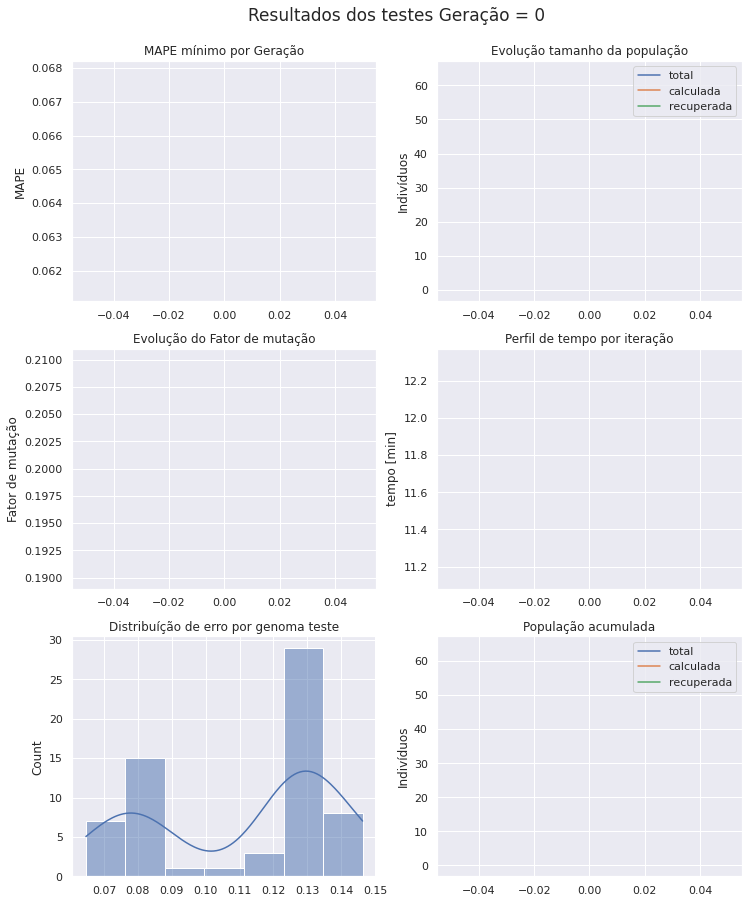

	 Min Erro Atual 0.06466 x 1.00000 Min Erro Anterior
	 parado a 0 epocas
-->>epoca 1 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [56 37 61 36 14 29 61 46 11 42 18 61 42]
Progenitores [ 6 46 56 49 45 62 28 47 39 53 56 50  7]
Progenitores [22  2 55 62 24  8 14  2  9 55 21 50 21]
Progenitores [63 59 61 25 54 48 52 41 48 48  3 36 40]
Progenitores [39 39 28 30 30 60 56 44 57 30 10 48  4]
Progenitores [41 50  3 23 39  2 50 27  4 11 62 56 13]
Progenitores [56 17 36 19 42  1 33 27  7 25 13  7 40]
Progenitores [35 49 28 32 58 19  4 43 15 37 26 52 15]
Progenitores [41 48 40 37 28  9 63  5 47  0  4  1 60]
Progenitores [12 52  4 12  7 55 43 22 47 30 13 48 59]
Progenitores [26 13 49  7  6  4  0 42 25 49 59 14 12]
Progenitores [ 5 38  4 21 33 28 22 48 23 30 58 63 32]
Progenitores [ 6  9 49 29 12 41  5  7 26  5 27 60 27]
Progenitores [22  5 59 50 16 11 48 35 51 61 63 45 46]
Progenitores [40 38 43 35 61 28 44 49 53  

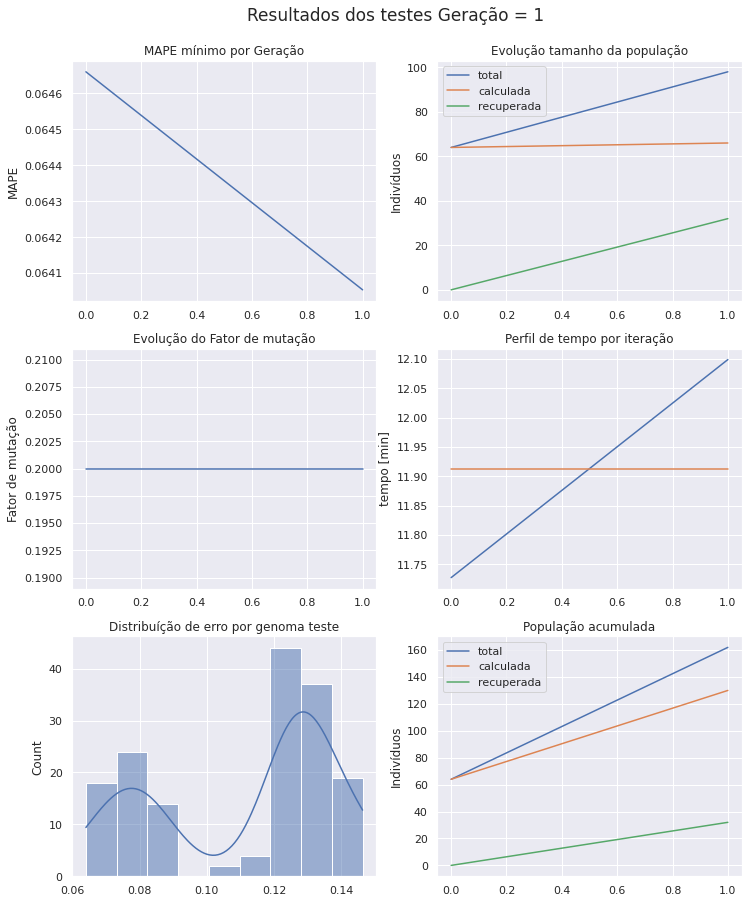

	 Min Erro Atual 0.06405 x 0.06466 Min Erro Anterior
	 parado a 0 epocas
-->>epoca 2 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [28 29 52  2 36 20 53 59 47  3 46 14 25]
Progenitores [11 11  5  2 11 30 47  3 28  7 29 47 41]
Progenitores [12 52 40 37 28  9 43  5 47 30  4  1 60]
Progenitores [56 17 36 19 42  1 33 27  7 25 13  7 40]
Progenitores [46 59 46 53 36 32 56 60 57 31 15 31  9]
Progenitores [52 53 47  4 41 61 33 12 42 48 39 22 48]
Progenitores [41 50 28 23 30 60 50 27  4 30 62 56  4]
Progenitores [ 4  0 47 23 52 11 45  0 14 47 49 27  2]
Progenitores [31 12 50 41 34 45 42  9 31 26 44 43 18]
Progenitores [40 38 43 35 61 28 44 49 53  4 58 11 54]
Progenitores [30  8 56 18 30 28  7 10 20 58 53 53 13]
Progenitores [ 3 11  6 28 50 41  7 37 53  8  9 39 21]
Progenitores [55 45  8  2 59 17 12 33 19  6 47  3 18]
Progenitores [ 5 38  4 21 33 28 22 48 23 30 58 63 32]
Progenitores [31 28 50 23 34 55 12  9 17 5

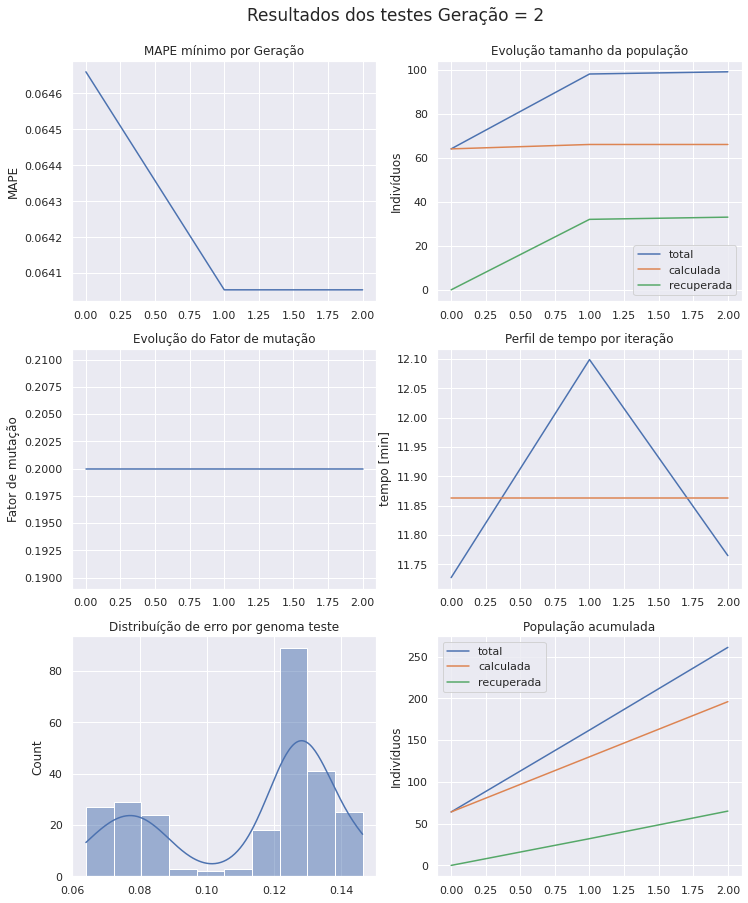

	 Min Erro Atual 0.06405 x 0.06405 Min Erro Anterior
	 parado a 1 epocas
-->>epoca 3 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [52 53 17 41 41 61 41 12 18 48 39 25 48]
Progenitores [40 38 43 35 61 28 44 49 53  4 58 11 54]
Progenitores [28 58 23 17 26  1 23 21 22 11 59 30 51]
Progenitores [25  5 59 23  8 25 48 35 15 61 63 45 46]
Progenitores [38 50  4 46 16  8  8  8 30 37  5 59 26]
Progenitores [32 31 49 56 12 41  5 54 21 26 15 40 27]
Progenitores [ 5 44  6 56 29 59 43 38 45 14 35 18 26]
Progenitores [28 59  3  8  1 47 21 15 43 10  4 11 21]
Progenitores [46 59 46 53 36 32 56 60 57 31 15 31  9]
Progenitores [40 50 62 55 40 46  9 27 48  1 40 18 23]
Progenitores [28 29 52  2 36 20 53 59 47  3 46 14 25]
Progenitores [11 11 52  2 11 30 53  3 47  7 29 14 41]
Progenitores [12 52 40 37 28  9 43  5 47 30  4  1 60]
Progenitores [ 3 11  6 28 50 41  7 37 53  8  9 39 21]
Progenitores [30 61  3 55 33 43  1 46 44 3

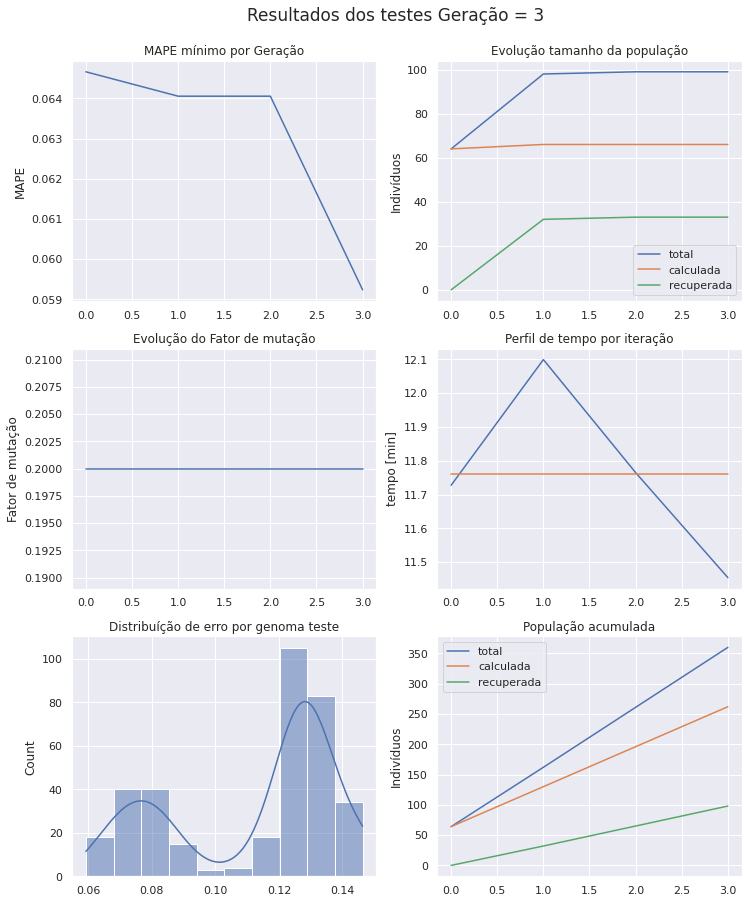

	 Min Erro Atual 0.05924 x 0.06405 Min Erro Anterior
	 parado a 0 epocas
-->>epoca 4 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [31 28 50 23 34 55 12  9 17 53 44 60 18]
Progenitores [46 17 15 29 22 56 16 62 51 61 55 32 32]
Progenitores [29 62 39  3 14 63 36 12 33 60  2 19  5]
Progenitores [ 9 53 33 31 63 48 27 17  5 38 58 58 34]
Progenitores [56 17 40 37 28  1 43 27  7 30 13  1 40]
Progenitores [31 28  4 23  7 55 12 22 17 30 44 60 59]
Progenitores [ 5 18 18  1 33 37 18 33 14 28 19  6 53]
Progenitores [32 15 59 45 24  0 63  6 40 55 59 27 42]
Progenitores [ 3 11 56 28 50 28  7 10 20  8 53 39 21]
Progenitores [55 45  8  2 59 17 12 33 19  6 47  3 18]
Progenitores [40 34 62 22 13 52 33 43 41 39 10 38 10]
Progenitores [25  5 59 23  8 25 48 35 15 61 63 45 46]
Progenitores [55 35  4 50 16 28  8 20 51 28 58  3 32]
Progenitores [ 3 52  6 28 28 41  7 37 53 30  4  1 21]
Progenitores [54 14 62 54 40 13 50 49 63 3

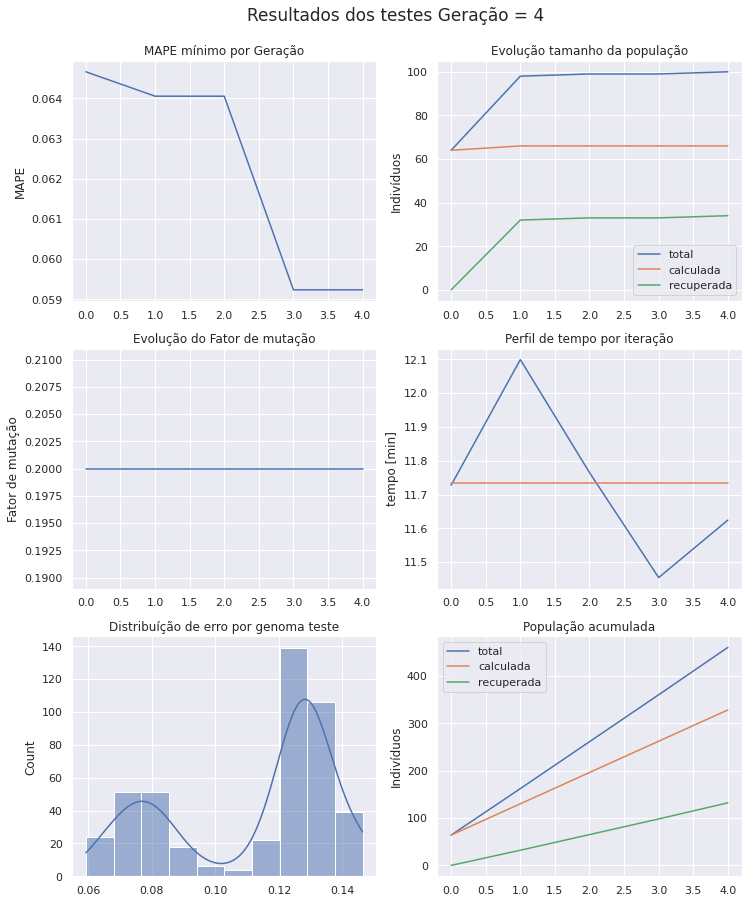

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 1 epocas
-->>epoca 5 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [43 14 60 29 17 43 49 16  1 15 50 15 59]
Progenitores [25 46 25 60  8 25 21 41 29 61 63 45 61]
Progenitores [53 15  6  7 19 41 10 14 41 40 57 25 36]
Progenitores [58 46 30 35 37 53  5 12 56 34 54 43  4]
Progenitores [31 28 50 23 34 55 12  9 17 53 44 60 18]
Progenitores [57 57 30 30 11  7 35 52 20 18 43  7 12]
Progenitores [ 8 26 28 19 30 23 18 59 50 36 11  3 62]
Progenitores [12 49 56 40  6 55 36  5  3 63 54 32 28]
Progenitores [13  6 59 51 58  9 12  7 15 41  3 41 15]
Progenitores [ 3 52  6 28 28 41  7 37 53 30  4  1 21]
Progenitores [10 15 51 20 45 35 54  6 62 49 11 25  7]
Progenitores [31 28 40 23 28  1 12 22 17 30 44 60 40]
Progenitores [29 62 39  3 14 63 36 12 33 60  2 19  5]
Progenitores [30  8  9 14 16 13 54  9 14  4 39 20 11]
Progenitores [25 58 23 17 22 45 23 21 22 3

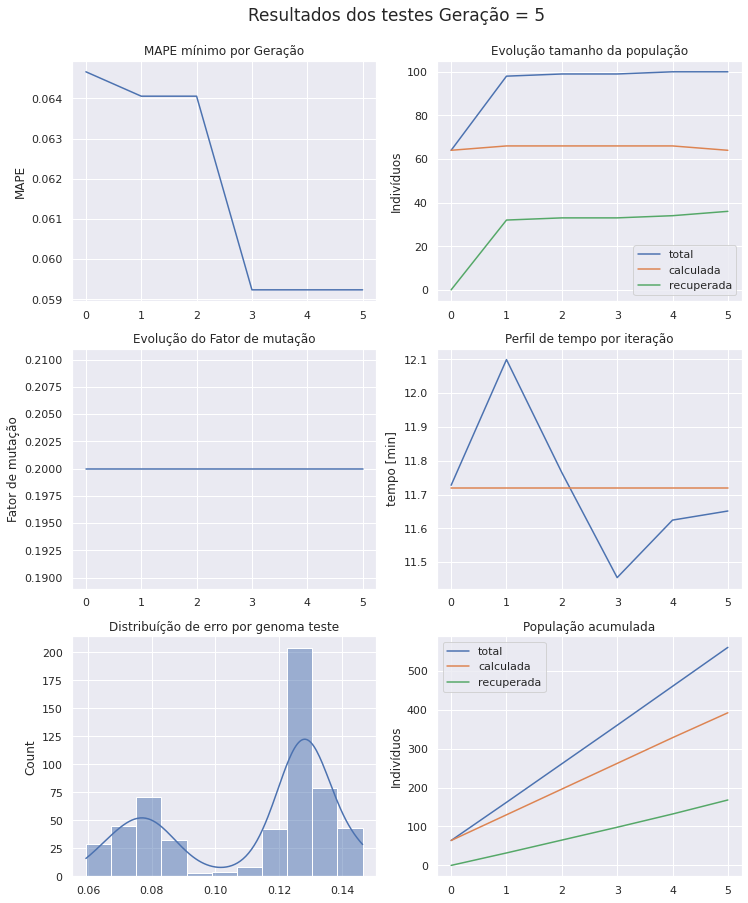

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 2 epocas
-->>epoca 6 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [25 58 23 17  8 25 23 21 22 61 63 45 51]
Progenitores [29 62 39 31 63 48 27 12 33 60 58 19 34]
Progenitores [22 61 21  5 52  0 47 17 55 29 44 55 56]
Progenitores [12 49 56 19 30 23 36 59  3 63 11 32 62]
Progenitores [12 49 56 40  6 55 36  5  3 63 54 32 28]
Progenitores [34 44 28  5 38 34 49 30 58 43 53 13 20]
Progenitores [ 8 26 28 19 30 23 18 59 50 36 11  3 62]
Progenitores [32 15 59 45 24  0 63  6 40 55 59 27 42]
Progenitores [46 17 50 53 50 56 12 37 53  4 44 21 60]
Progenitores [63 58 42 13 19 59 47 12 37 25 24 13 22]
Progenitores [19 15 34 49 60 56 58 59 19 60 35 46 11]
Progenitores [46 17 50 23 22 56 12 62 17 53 44 60 18]
Progenitores [43 44 16 25 47 15 39  8  4 46  6 30 60]
Progenitores [57 28 50 23 11 55 35 52 17 53 44 60 12]
Progenitores [25 58 23 17 22 45 23 21 22 3

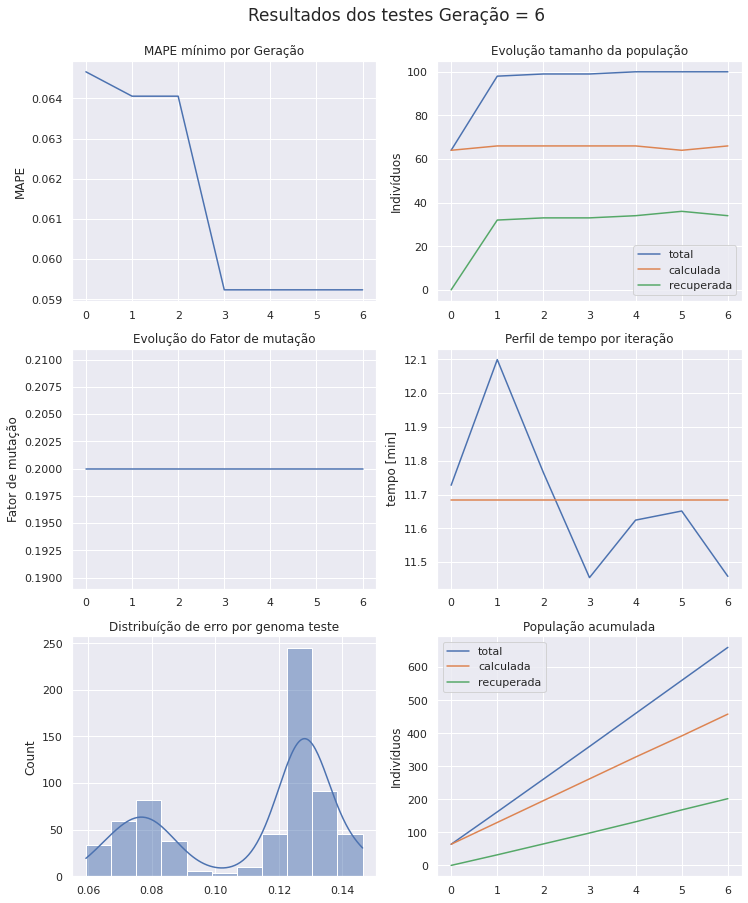

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 3 epocas
-->>epoca 7 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [29 58 57 14 27 13  7 50 62  7 25 40 59]
Progenitores [46 17 50 49 60 56 58 62 17 60 44 46 11]
Progenitores [ 7 44 22 10 62 23 41 61 44 26  7 54 30]
Progenitores [29 62 39 31 63 48 27 12 33 60 58 19 34]
Progenitores [32 15 59 19 24 23 18 59 40 55 59 27 42]
Progenitores [57 28 16 25 47 55 39 52  4 46 44 30 60]
Progenitores [ 3 16 14 49 10 43 57 23 63 31 14 21 61]
Progenitores [13 52 59 51 58 41  7 37 53 41  3 41 15]
Progenitores [41 50  4 28 24 17 28 39 22 38 14 22 57]
Progenitores [26 37 29 42 21  3  0  8 21 16 36 58 59]
Progenitores [19 15 34 49 60 56 58 59 19 60 35 46 11]
Progenitores [56  1 20 44 51 59 56  5 22  1 56 61 27]
Progenitores [48 57 53 27  0 44 45 56 54 50 25 57 25]
Progenitores [10 15 51 20 45 35 54  6 62 49 11 25  7]
Progenitores [29 44 62 50 14 63 54 12 63 4

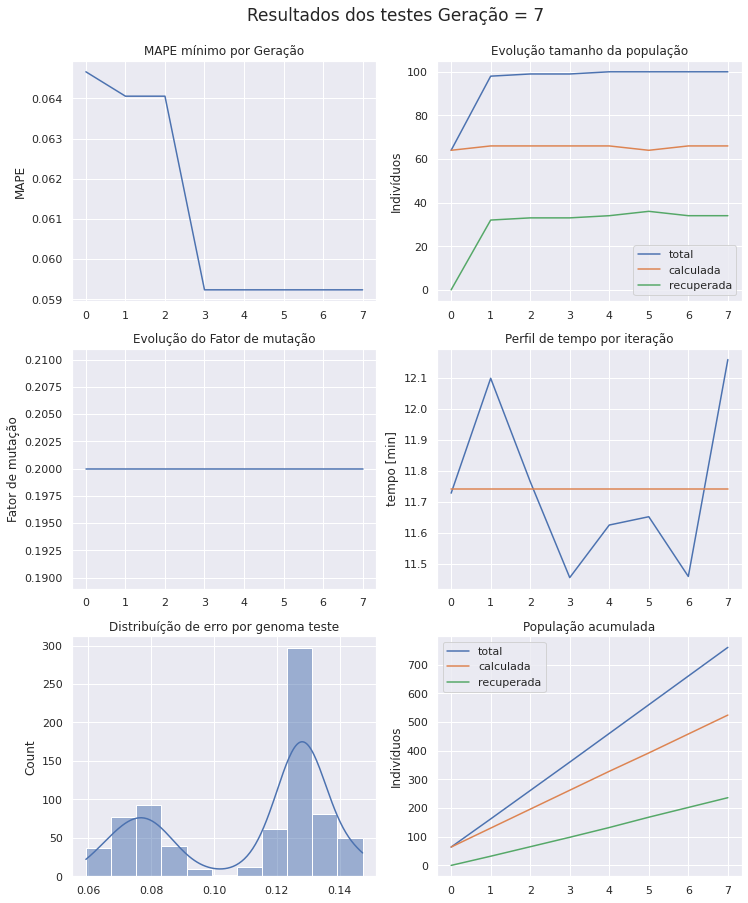

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 4 epocas
-->>epoca 8 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [29 35 43 43 63 25 43 43 61 50 44 41 27]
Progenitores [26 37 29 42 21  3  0  8 21 16 36 58 59]
Progenitores [57 28 16 25 47 55 39 52  4 46 44 30 60]
Progenitores [62  9  4 62 14 32 61 59 25  4 40 19  5]
Progenitores [ 7 44 22 10 62 23 41 61 44 26  7 54 30]
Progenitores [24 45 62 51  2 63 54 12 58 49  2 20 60]
Progenitores [42  7  9 14  1 11 32 10 17 54 33 33 29]
Progenitores [40 28 33 23 41  2 13 45 23 46 42  0 55]
Progenitores [41 50 29 28 21  3 28 39 22 38 14 58 59]
Progenitores [22 36 56 48 56 50  2 57 29 48 28  3 32]
Progenitores [31 28 40 23 28  1 12 22 17 30 44 60 40]
Progenitores [ 3 26 61 42 53 26 55 26 35 36 50  2 34]
Progenitores [42 60  0 25 31 31 24 36 54 43 33  6 21]
Progenitores [46 17 50 49 60 56 58 62 17 60 44 46 11]
Progenitores [54  8 62 50 55 62 32 17 32  

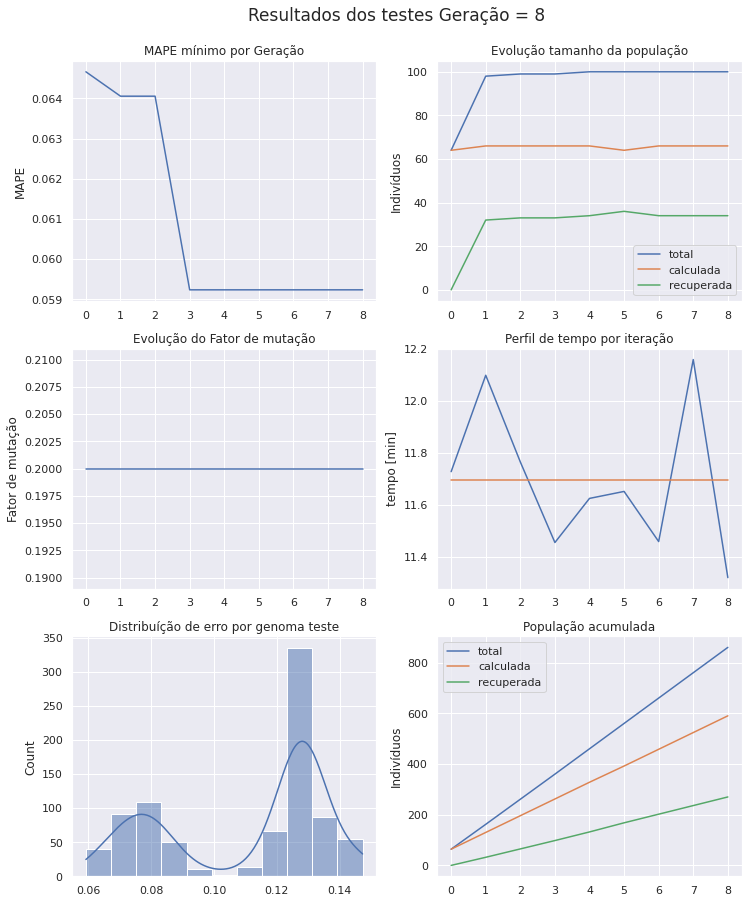

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
Indice Mutação:  0.30000000000000004
	 parado a 0 epocas
-->>epoca 9 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [40  7 33 14  1  2 32 45 23 46 42 33 29]
Progenitores [46 58 50 17 19 56 12 21 22 39 54 45 51]
Progenitores [42 57 38 57  7 24 32 41 38 46 48 49 27]
Progenitores [24 45 62 51 62 23 41 61 58 26  7 20 60]
Progenitores [ 4 22 14 35 20 47 37 47 62  3 14 37 57]
Progenitores [ 3 16 14 49 10 43 57 23 63 31 14 21 61]
Progenitores [14 44 34 51 50 50 21 14 56 52 30 17 38]
Progenitores [63 37 30 26 57  1 16 62  8 59 23 54 60]
Progenitores [63 16 30 26 57 43 57 62 63 31 14 21 61]
Progenitores [26 37 29 42 21  3  0  8 21 16 36 58 59]
Progenitores [56 58 20 14 27 59 56  5 22  1 25 40 27]
Progenitores [ 3 26 61 42 53 26 55 26 35 36 50  2 34]
Progenitores [37 15 59 39 20 31 25 60  0 32 25 63 50]
Progenitores [62  9  4 62 14 32 61 59 25  4 40 19  5]
Proge

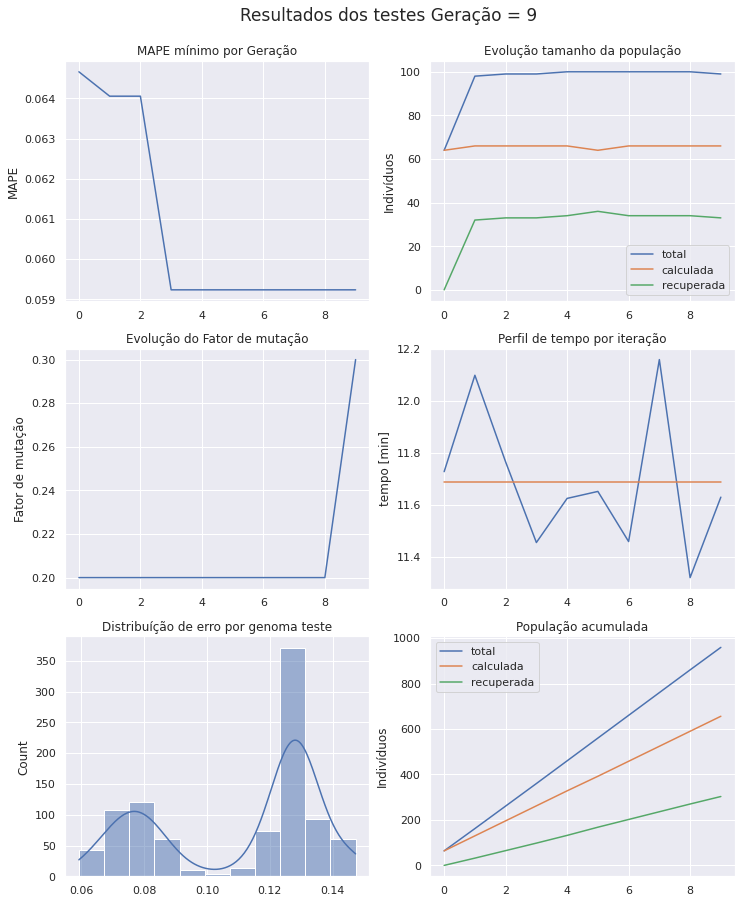

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 1 epocas
-->>epoca 10 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [43  5 17 25  0 62  9 44 54 22 19 54 61]
Progenitores [30 43 59 21 43 62 21  6 55 50 43 39 58]
Progenitores [28  8 25 22 46 13 22  2 21 45 32 25 41]
Progenitores [42 45 38 51  7 24 41 61 58 46  7 49 60]
Progenitores [63 37 30 26 57  1 16 62  8 59 23 54 60]
Progenitores [25 58 23 17 22 45 23 37 22 39 54 45 51]
Progenitores [ 3 16 14 49 10 43 57 23 63 31 14 21 61]
Progenitores [63 16 30 42 57  3  0  8 21 31 14 21 61]
Progenitores [25  5 23 52 62  1 29 63 42 30 16 44 46]
Progenitores [ 3 58 20 42 53 26 56 26 35  1 50  2 27]
Progenitores [ 2 63  1 57  1 21 27 24 35 50  0 25 26]
Progenitores [40 58 33 17  1  2 32 21 23 46 54 33 29]
Progenitores [31 11 23 45  9 38 20 49 47  3  0 59 44]
Progenitores [ 3 16 14 35 20 43 57 47 62  3 14 21 61]
Progenitores [59 36 45  3 11 57 48 33 37 

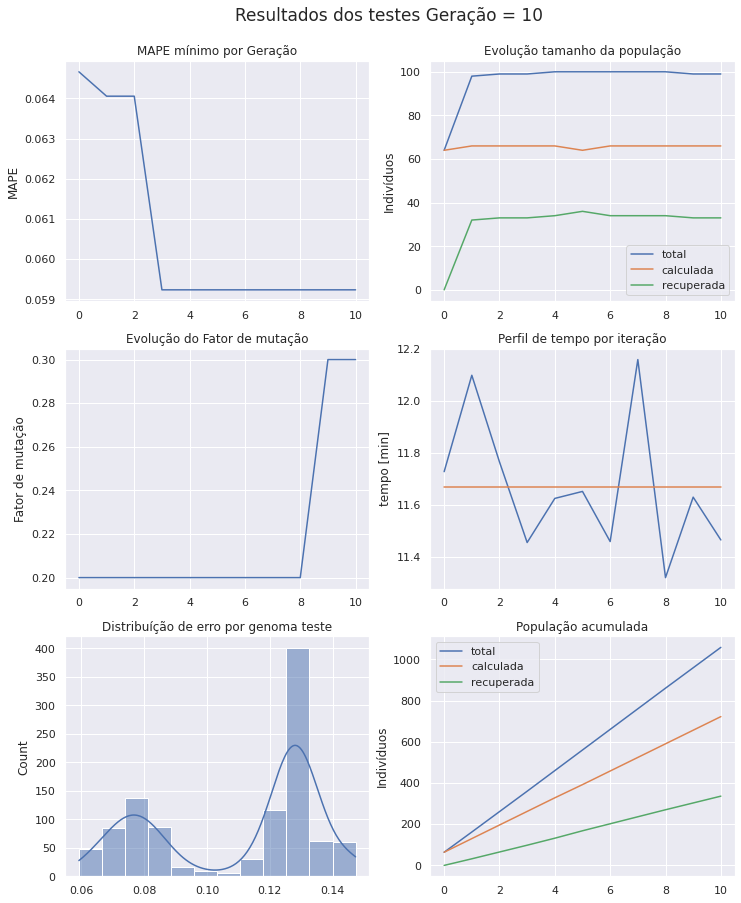

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 2 epocas
-->>epoca 11 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [ 2 63  1 57  1  2 32 21 23 50 54 33 29]
Progenitores [52 53 43 35 61 32 33 12 53 48  0 28 48]
Progenitores [22 22 56 28 20 47  2 57 62  3 28 37 32]
Progenitores [30 24 59 27  0 21 53  2 20 26 34 11 48]
Progenitores [ 3 58 23 52 53  1 56 26 35 30 16 44 46]
Progenitores [39 59 48 18 12 38 27  8  8 53 42 33 62]
Progenitores [25  5 20 42 62 26 29 63 42  1 50  2 27]
Progenitores [46 44 17 28 39 12 43  7  8 59  5 58  5]
Progenitores [18  6 11  1  2 34 53 42  1 28 52 36 38]
Progenitores [ 2 33 38  7 28 59 14 48 47 21 23 35 13]
Progenitores [30 43 59 21 43 62 21  6 55 50 43 39 58]
Progenitores [25 19 48 50 60 20 11 29 44  6 61 40 16]
Progenitores [57 15 61 14 59 60 55  5 22 36 25 34 29]
Progenitores [22 36 56 28 21  3  2 57 29 48 28  3 32]
Progenitores [17  5 35 43 40 41 42 62 22 

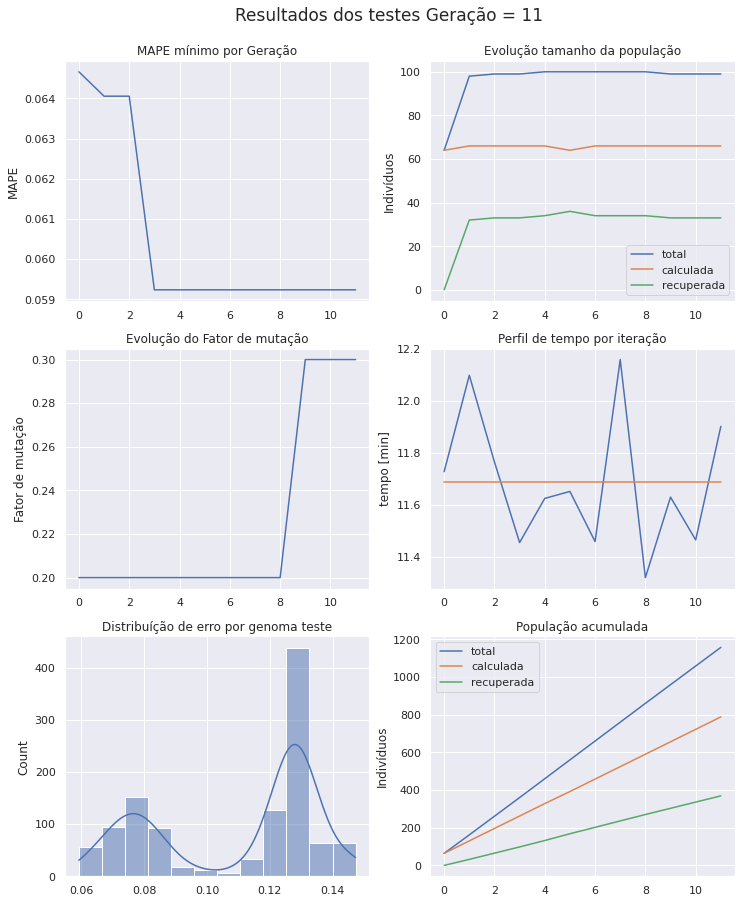

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 3 epocas
-->>epoca 12 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [37 14 43 32 50 35 10 54 55 52 60 47  9]
Progenitores [ 3 59 23 18 12  1 27  8  8 53 16 44 62]
Progenitores [ 4 15 31 61 29  2 19 39 48 50 42 46 59]
Progenitores [14 50 60 26 36 44 14 17 46 14  3 35 26]
Progenitores [ 7 20 45 56 35 49 51 62 32 50 60 14 33]
Progenitores [57 15 61 14 59 60 55  5 22 36 25 34 29]
Progenitores [12 44 22 39  4 34 11 19 16 52 51 60 49]
Progenitores [53  7  1  5  9 47 28 20 36 24 34 21 26]
Progenitores [52 53 43 35 61 32 33 12 53 48  0 28 48]
Progenitores [25 58 23 26 57  1 16 62  8 39 54 45 60]
Progenitores [18  6 11  1  2 34 53 42  1 28 52 36 38]
Progenitores [23 52 12 28  8 55 45 11 21  6  3 56 63]
Progenitores [ 3 16 14 45  9 43 57 49 47  3 14 59 44]
Progenitores [42 35 13 51 33 24 41 61 23 46  7 49 24]
Progenitores [30 43 48 21 60 62 11 29 55 

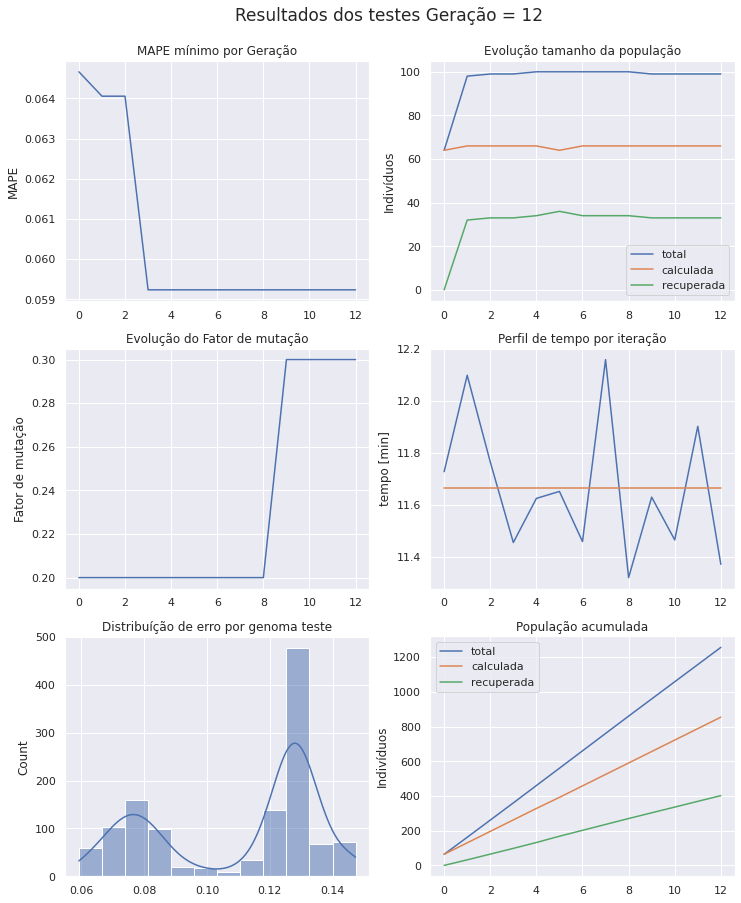

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 4 epocas
-->>epoca 13 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [42 45 38 51  7 24 41 61 58 46  7 49 60]
Progenitores [42 45 38 28 21  3 41 61 58 46  7 49 60]
Progenitores [ 4 15 31 61 36 44 14 39 48 50  3 35 59]
Progenitores [42 35 13 51  9 24 41 61 47 46 14 49 24]
Progenitores [ 4 15 31 61 29  2 19 39 48 50 42 46 59]
Progenitores [55 16 51 23  3 31 15 18 63 17 18 57 53]
Progenitores [37 14 43 32 50 35 10 54 55 52 60 47  9]
Progenitores [57 15 61 14 59 60 55  5 22 36 25 34 29]
Progenitores [22 24 59 28 20 47  2  2 62 26 28 37 32]
Progenitores [46 44 17 28 39 12 43  7  8 59  5 58  5]
Progenitores [14 50 60 26 29  2 19 17 46 14 42 46 26]
Progenitores [ 7 20 45 56 35 49 51 62 32 50 60 14 33]
Progenitores [22 36 56 28 21  3  2 57 29 48 28  3 32]
Progenitores [56  4 42 23  1 31 18 59 56 35 37 23 18]
Progenitores [25 19 59 50 43 20 21  6 44 

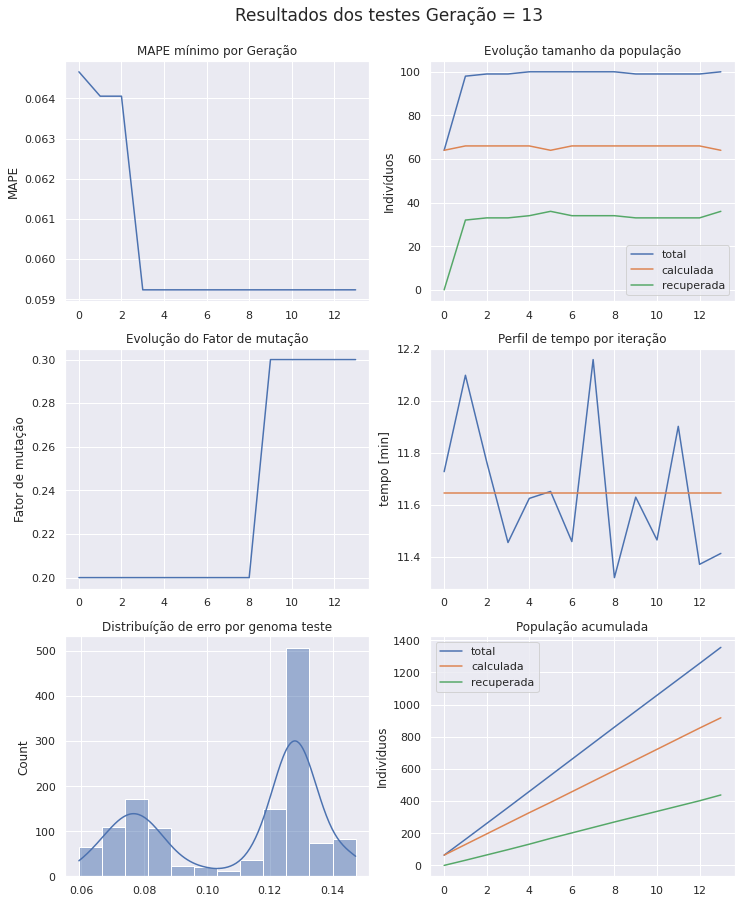

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
Indice Mutação:  0.4
	 parado a 0 epocas
-->>epoca 14 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [ 4 15 31 61 29  2 19 39 48 50 42 46 59]
Progenitores [36 18 27 28 37 52 38 50 30 57 50 46  7]
Progenitores [22 24 59 28 20 47  2  2 62 26 28 37 32]
Progenitores [25 44 34 51 20 50 21 14 62 52 14 17 38]
Progenitores [ 4 39 60  3 34 34 42 14 18 38 38 58 48]
Progenitores [39 44 34 51 27 50 16 14 29 52 14 17 38]
Progenitores [22 36 56 28 21  3  2 57 29 48 28  3 32]
Progenitores [30 33 48  7 60 59 14 29 47 21 23 39 58]
Progenitores [24 19 37 30 38 47 39  5 15 63 49 23 32]
Progenitores [52 53 43 35 57 32 33 62 53 48  0 28 48]
Progenitores [42 35 13 51 33 59 41 20 36 41  3 49 24]
Progenitores [54  8 40 24 38 54 11 36 38 46 20 26 19]
Progenitores [57 20 45 56 35 60 51  5 32 50 60 14 29]
Progenitores [25 19 56 46 43  3 55  1 44 36 25 34 29]
Progenitores [52 53 

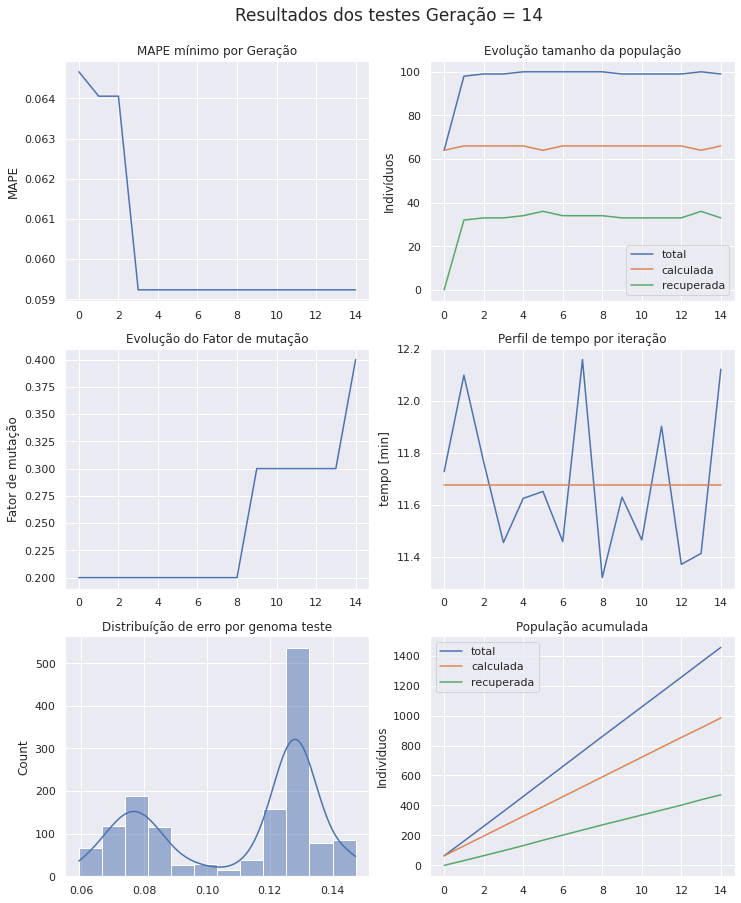

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 1 epocas
-->>epoca 15 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [36 18 27 28 37 52 38 50 30 57 50 46  7]
Progenitores [48 61 24 48 54 45 30 16 46 33 45  2 28]
Progenitores [44 39 33 20  7 46 35  5 27 31 54 45  6]
Progenitores [58 38 62 33 46 20 60  2 57 38 55 55 13]
Progenitores [24 19 37 30 38 47 39  5 15 63 49 23 32]
Progenitores [57 20 45 56 35 60 51  5 32 50 60 14 29]
Progenitores [20 25 17 46 34 58 14 18 58 61 62 62 10]
Progenitores [ 6 61 11 19 36 59 34 56  0 49 31 48  5]
Progenitores [57 19 56 56 35 60 55  5 32 36 25 34 29]
Progenitores [25 19 56 46 43  3 55  1 44 36 25 34 29]
Progenitores [ 0 53 46 17 30 32 35 40 54 14 25 16 24]
Progenitores [52 53 43 24 38 54 11 36 38 46  0 28 19]
Progenitores [27 43  1 18 63 30 32 26 20 30 39  0 22]
Progenitores [30 33 48  7 60 59 14 29 47 21 23 39 58]
Progenitores [17 54 26 50  8 57 23 30 47 

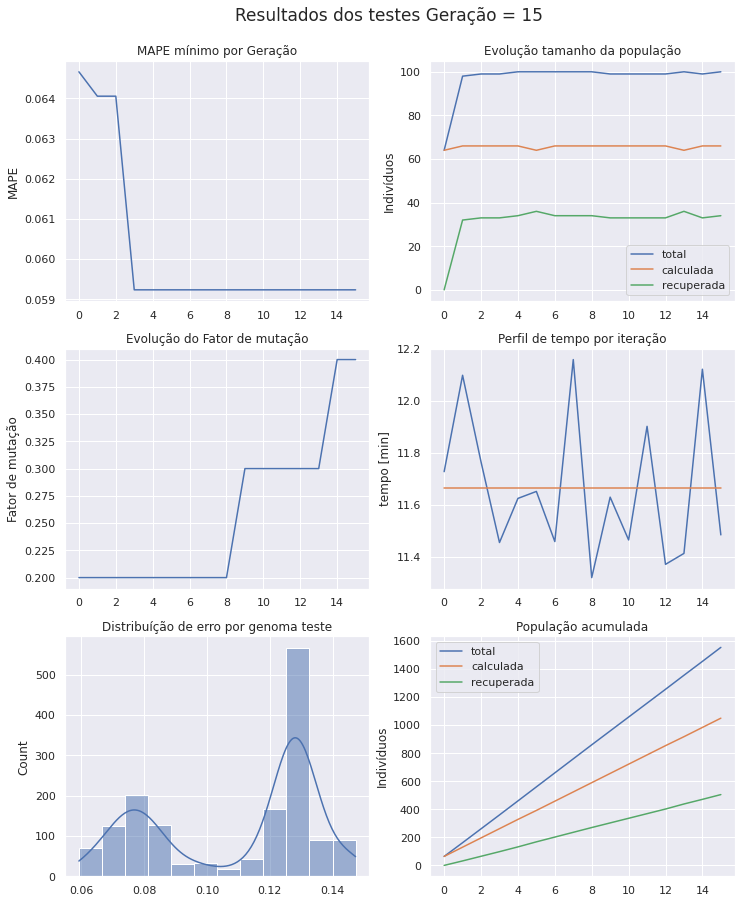

	 Min Erro Atual 0.05924 x 0.05924 Min Erro Anterior
	 parado a 2 epocas
-->>epoca 16 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [32 42 39 24 33 29 36 61 23 33  3 14 12]
Progenitores [30 28 13 56 43 40 26 54 16 46 27 62  7]
Progenitores [15 42 41 32  3 52  4 49 51 27 23 56 31]
Progenitores [44 39 33 20  7 46 35  5 27 31 54 45  6]
Progenitores [10 62 49 53  1 44  4 46 60 49 14  7 59]
Progenitores [31 34  4 12  1 51 28 14 37 22 55 25 41]
Progenitores [20 61 17 46 34 58 34 18 58 49 62 48 10]
Progenitores [53  6 10 33 63 62  2  6  7 19 32 32  3]
Progenitores [20 57 58 21 50 46 29 44 37 22 27 54 12]
Progenitores [39 23 29 43 60 24  1 45 35 21 21 56 57]
Progenitores [52 35 43 35 38 32 11 36 36 48  0 28 24]
Progenitores [48 61 24 48 54 45 30 16 46 33 45  2 28]
Progenitores [57 33  0 42 36 63 59 61 28 38  5  7 35]
Progenitores [44 38 62 20  7 46 35  5 27 31 54 55 13]
Progenitores [42  8 40 51 33 54 41 20 38 

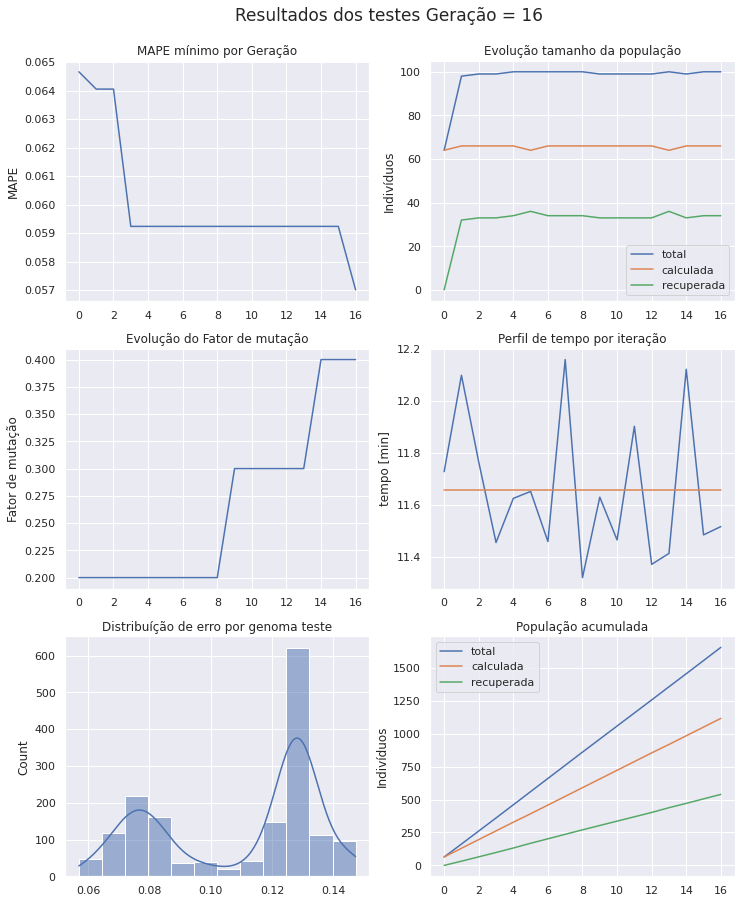

	 Min Erro Atual 0.05701 x 0.05924 Min Erro Anterior
	 parado a 0 epocas
-->>epoca 17 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [57 31 48 49 48 42 22 30 50  0 34 20 15]
Progenitores [10 18 27 59 17 26 39  0  8 13 24 12 49]
Progenitores [27 32  1 18 48 11 37 29 43 21 27 20 58]
Progenitores [35 51 31  4 12 53 40 45 46 15  7 22 31]
Progenitores [25 44 34 51 20 50 21 39 62 52 14 58 59]
Progenitores [31 34  4 12  1 51 28 14 37 22 55 25 41]
Progenitores [43 56 37 25 62  4 29 22 32 63 22 34 10]
Progenitores [52 61 24 35 38 45 30 16 46 48  0  2 24]
Progenitores [17  2 14 46  2 31  8 13 28 41 26 39 18]
Progenitores [20 23 55 28 28 59 57 15 45 33  0  1 24]
Progenitores [37 57 46 23  5 24 11 26 53 34 16 41 19]
Progenitores [15 42 41 32  3 52  4 49 51 27 23 56 31]
Progenitores [48 61 24 48 54 45 30 16 46 33 45  2 28]
Progenitores [34 63 50 10  4  3  4 40  7 42 58 48  2]
Progenitores [25 36 10 32 45 54 56 51 33 

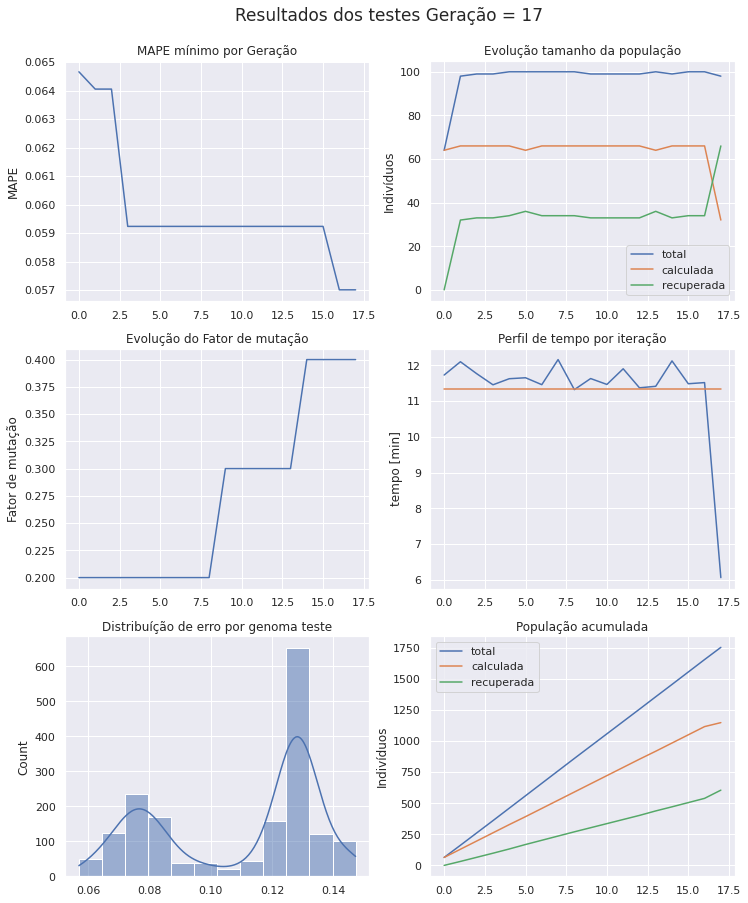

	 Min Erro Atual 0.05701 x 0.05701 Min Erro Anterior
	 parado a 1 epocas
-->>epoca 18 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [57 52 35  1  8 50 29 59 60 30 57 52  6]
Progenitores [43 39 20 51  8 53 61 23 50 35  0  7 15]
Progenitores [32 15 59 45 24  0 63  6 40 55 59 27 42]
Progenitores [30 28 13 56 33 40 36 61 23 33 27 14  7]
Progenitores [39 38 10 20  7  4 35  5 27 31 20 55 29]
Progenitores [52 61 24 35 38 45 30 16 46 48  0  2 24]
Progenitores [41 15 33 11 52 50 22 39 36 58 24 24 46]
Progenitores [23 57 46 56 12 45 57 34  8 45  2 35 59]
Progenitores [17  2 14 46  2 31 57 15 28 41 26 39 24]
Progenitores [49  0 54 26  5 27 16 35 40 54 28 52 59]
Progenitores [15 35 43 35 38 32 35  5 36 27 23 56 31]
Progenitores [24 55 52 50 63 17 52 24  3 11 44 59 14]
Progenitores [37 57 46 23  5 24 11 26 53 34 16 41 19]
Progenitores [52 35 43 35 38 32 11 36 36 48  0 28 24]
Progenitores [52 42 33 20  3 46 11 36 27 

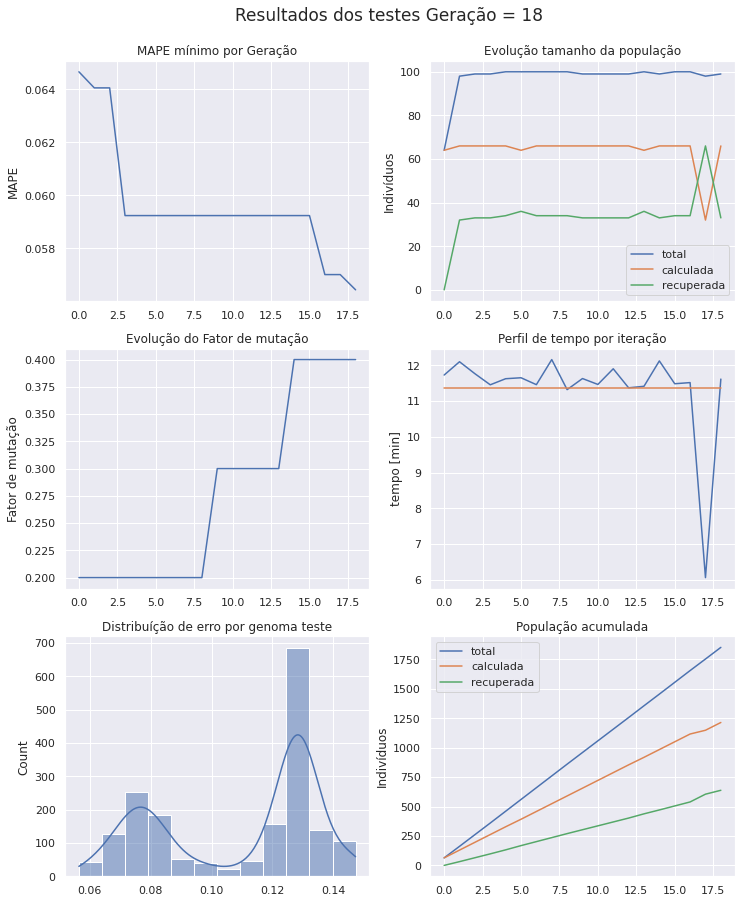

	 Min Erro Atual 0.05644 x 0.05701 Min Erro Anterior
	 parado a 0 epocas
-->>epoca 19 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [54 60 11 37 46 15 15 29 13  6  1 41 25]
Progenitores [52 42 33  8  3 46  0 36 27 23 54 28 13]
Progenitores [ 6 46 15  1 50 22 14 55 63 50 29 22 43]
Progenitores [48 31 59 63 12 46  4 62  7 29 24 36 58]
Progenitores [39 56 10  8 29  4  0 52 49 23 20 60 29]
Progenitores [15 35 43 35 38 32 35  5 36 27 23 56 31]
Progenitores [20  3 58 51 20 17 11  3 11 37 54 54  9]
Progenitores [53 52 52  1  9 29 42 25 47 23  8 11 14]
Progenitores [25 34 34 51 20 50 28 39 62 22 14 25 59]
Progenitores [62 42 31 12 47 48  6 47 36 56 34 11 41]
Progenitores [49  0 14 46  2 27  8 13 40 15 26 22 18]
Progenitores [17 54 33 15 37 63 32 39 58 63 58 36  0]
Progenitores [25 46 13 60 22 46 21 41 29 33 54 55 35]
Progenitores [29  2 32 63 48 49 34  7 32 57 51 35 52]
Progenitores [52 61 24 35 38 45 30 16 46 

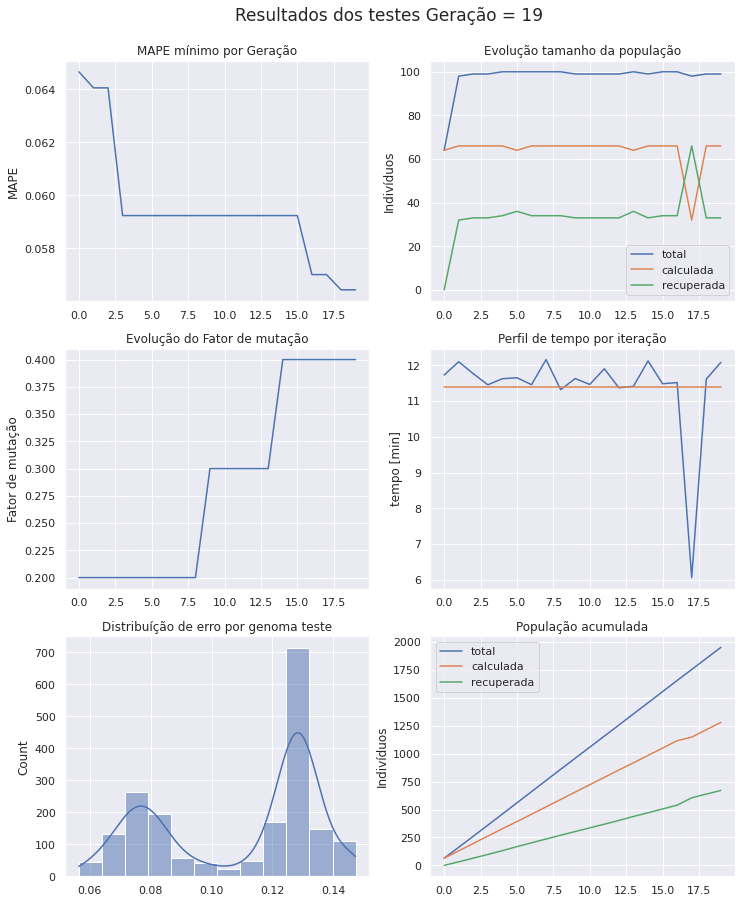

	 Min Erro Atual 0.05644 x 0.05644 Min Erro Anterior
	 parado a 1 epocas
-->>epoca 20 ----------------------------------------------------
-->>>Seleção---------------------------------------------------
Progenitores [17  2 14 46  2 31  8 13 28 41 26 39 18]
Progenitores [48 31 59 63 12 46  4 62  7 29 24 36 58]
Progenitores [44 17 52 63 62 21 62  1 25 55 51 29 55]
Progenitores [42 63 49 11 27 30 24 20 63 24 50 28  5]
Progenitores [52 61 46 23  5 45 11 26 46 34 16  2 19]
Progenitores [12 34 39 35 28 34 25 15 54 56 40 63 35]
Progenitores [ 8 12 39 33 48  1  0 12 32 43 52 24 54]
Progenitores [17  2 49 11  2 30 57 20 63 41 50 39  5]
Progenitores [35  0  1 51  5 53 37 35 40 22 14 52 59]
Progenitores [30 33 13 20  7 46 36 61 27 33 54 55 35]
Progenitores [39 56 10  8 29  4  0 52 49 23 20 60 29]
Progenitores [35 32 10 40 48  4 42  6 18 36 60  9  1]
Progenitores [28 13  6 39 51 25 21 27 25  3 47 20  6]
Progenitores [52 61 24 35 38 45 30 16 46 48  0  2 24]
Progenitores [39 35 43  8 29 32  0  5 49 

In [ ]:
%%time
# Parâmetros de entrada: 
ini_pop       = True        # Inicializa população aleatória
pop_selecao   = 0          # N melhore hist Selecionados para geração 0 
recup_memo    = False        # True recupera memória de iterações passadas
epocas        = 100          # total de gerações/Epocas
pop_tamanho   = 64          # tamanho da inicial população
n_genes       = 13           # Número de Genes
limites_genes = (0,64)      # Limite de valores para cada Gene
indice_mut    = 0.2         # Probaabilidade de Mutação inicial 
casais        = int((pop_tamanho+pop_selecao)/4)  # Número de casais Progenitores
max_parado    = 200         # Limite de epocas parado no mesmo erro
alvo          = 0.00001     # Erro Alvo

#------------------------------------------------------------------------------
arca_gen        = []           # Memória genetica
arca_apt        = []           # Memória de aptidão 
arca_mape       = []           # Memória de mape 
teste_mape      = []
count_parada    = 0
count_pop_r     = 0
count_pop_c     = 0
res             = []
elite           = []
list_mutacao    = []
list_tdiff      = []
list_t_pop      = []
list_t_pop_r    = []
list_t_pop_c    = []
novos_individuos= []
pre_selecionado = []
selecionado     = []
pop             = []

min_anterior  = 1
test_comb     = epocas*pop_tamanho
max_comb      = ((limites_genes[1]-limites_genes[0])+1)**n_genes


print('->Algoritmo genético de otimização -----------------------------------')
print(  '\t Nova Populaçao                         = '  , ini_pop       ,
      '\n\t Recupera memória de iterações passadas = '  , recup_memo    ,
      '\n\t Gerações máximas                       = '  , epocas        ,
      '\n\t Mais aptos selecionados em memória     = '  , pop_selecao   ,
      '\n\t Tamanho da população                   = '  , pop_tamanho   ,
      '\n\t Número de Genes                        = '  , n_genes       ,
      '\n\t Limite de valores para cada Gene       = '  , limites_genes ,
      '\n\t Probabilidade de Mutação inicial       = '  , indice_mut    ,
      '\n\t Casais por época                       = '  , casais        ,
      '\n\t Limite de épocas parado no mesmo erro  = '  , max_parado    ,
      '\n\t Erro Alvo                              = '  , alvo          ,
      '\n\t Total de combinações no teste          = '  , test_comb/20  ,
      '\n\t Tempo de execução estimado em horas    = '  , test_comb/20  ,
      '\n\t Total de combinações possíveis         = '  , max_comb      ,
      '\n\t Tempo máximo max comb. em anos         = '  , max_comb/175200
      )

if os.path.isfile(patha+'arca.csv') and recup_memo:
    arca_gen, arca_mape, arca_apt, dic_arca, dic_arca_i= recupera_arca()
    print('--------------------------------------------------------------------'
          ,'\n\t\t\t', len(arca_gen),'codigos recuperados'                
          ,'\n\t\t\t', f'{(len(arca_gen)/max_comb)*100:.5f} % da população avaliada' )
else: 
    dic_arca = {}
    dic_arca_i = {}
if ini_pop:
    print('-->Inicializa População............................................')
    pop = inicializa_populacao(pop_tamanho,n_genes,limites_genes)
    print('População Inicial:',pop)
if pop_selecao >0:
    for e, i in enumerate(arca_gen):
        if len(i) ==n_genes:
            pre_selecionado.append(i)
    print (len(pre_selecionado),'possiveis de seleção')    
    for e, i in enumerate(pre_selecionado[0:pop_selecao]):
        print (e,i, len(i))
        selecionado.append(i)
    pop += selecionado
for ep in range(epocas):
    T1 = datetime.now()
    gera_mape = []
    count_pop_r = 0
    count_pop_c = 0
    print('-->>epoca',ep,'----------------------------------------------------')
    #print('Novos Individuos:',novos_individuos)
    if ep > 0: 
        print('-->>>Seleção---------------------------------------------------')
        for i in progenitores.ravel():
            # Progenitores selecionados aleatóriamente  #####
            novos_individuos.append(pop[i])
            print("Progenitores", pop[i])
        for el in range(2):
            # Elite garantindo os 2 melhores da geração anterior
            bol, pos = busca_item_lista(elite[el],novos_individuos)
            if not bol:
                print('\t\t VIP', elite[el])
                novos_individuos.append(elite[el])
        pop = novos_individuos
        novos_individuos = []
    list_t_pop.append(len(pop))
    #print('Novos Individuos:',novos_individuos)
    probabilidades = []  
    print('-->>>Aptidão-------------------------------------------------------')
    for id, individuo in enumerate(pop):
        print(ep,'#', id, individuo)
        #bag, ibag = busca_item_lista(individuo, arca_gen)
        
        if tuple(individuo) in dic_arca:
            print('\t__Individuo Clone Recuperado da Arca #id:',
                  dic_arca[tuple(individuo)][0])
            a = dic_arca[tuple(individuo)][3]
            m = dic_arca[tuple(individuo)][2]
            print('\t arca_apt recuperado:',a)
            print('\t arca_mape recuperado:',m)
            count_pop_r +=1
        else:
            m,a,yp = func_aptidao(individuo)
            dic_arca[tuple(individuo)]=[len(dic_arca),individuo,m,a]
            dic_arca_i[len(dic_arca_i)]=individuo
            arca_gen.append(individuo)
            arca_apt.append(a)
            arca_mape.append(m)
            count_pop_c +=1
        #print(probabilidades)
        if m>1:
            probabilidades.append(0)
        else: 
            probabilidades.append(1-m)
        gera_mape.append(m)
        #print('\t\t individuo mape',individuo,m)
        #print('\t\t',gera_mape)
    list_t_pop_c.append(count_pop_c)
    list_t_pop_r.append(count_pop_r)
    probabilidades =(np.array(probabilidades)/sum(probabilidades))
    #print('\t população avaliada:', pop)
    print('\t Probabilidades:', np.round(probabilidades,4))
    print('-->>>Elite---------------------------------------------------------')
    
    prob_elite = np.sort(probabilidades).tolist()[-2:]
    elite = [   pop[probabilidades.tolist().index(prob_elite[0])],
                pop[probabilidades.tolist().index(prob_elite[1])]]
    print('\t\t Elite :', elite)

    print('-->>>Progenitores--------------------------------------------------')
    progenitores = selecao_de_progenitores(pop, probabilidades, casais) 
    print('-->>>Cruzamento----------------------------------------------------')
    for p in progenitores:
        f1, f2 = cruzamento(p,pop, n_genes)
        novos_individuos.append(f1)
        novos_individuos.append(f2)
    print('Novos Individuos F1:',f1)
    print('Novos Individuos F2:',f2)
    #print('Novos Individuos:',novos_individuos)
    print('-->>>Mutação-------------------------------------------------------')
    # Replicas com Mutação dos filhos 
    mutantes = [] 
    for en, ori in enumerate(novos_individuos):
        mu = mutacao(ori,indice_mut,n_genes)
        mutantes.append(mu)
    novos_individuos += mutantes
    # Replicas com mutação da elite
    mutantes2 = [] 
    print('Novos Individuos:',novos_individuos)
    for en, ori in enumerate(elite):
        mu = mutacao(ori,indice_mut,n_genes)
        mutantes2.append(mu)
    novos_individuos += mutantes2
    print('Novos Individuos:',novos_individuos)
    ## Resultados Parciais ----------------------------------------------------
    teste_mape += gera_mape 
    ge_mape_min = (min(gera_mape))              # Menor erro na geração
    res.append(ge_mape_min)     
    ge_mape_ind = arca_mape.index(ge_mape_min)  
    ge_mape_gen = arca_gen[ge_mape_ind]
    
    list_mutacao.append(indice_mut)             # Indice de proba Mutação
    list_tdiff.append(time_diff(T1))            # Tempo de Processamento 
    
    ar_mape_min = min(arca_mape)     # Menor erro histórico
    ar_mape_ind = arca_mape.index(ar_mape_min)  
    ar_mape_gen = arca_gen[ar_mape_ind]
  
    relatorio_parcial()

    #Salva resultados Parciais    
    idtest = n_genes
    salva_resultado(ep,res,list_mutacao,list_tdiff,list_t_pop,
                    list_t_pop_r,list_t_pop_c,idtest)
    salva_arca(ep,idtest)

    # Critérios de parada
    if ge_mape_min < alvo:
        print('para por atingimento do alvo')
        break
    print(f'\t Min Erro Atual {ge_mape_min:.5f} x {min_anterior:.5f} Min Erro Anterior')
    if round(ge_mape_min,5) == round(min_anterior,5):
        count_parada +=1
        if count_parada > 4:
            if indice_mut < 0.81:
                indice_mut += 0.1
                print('Indice Mutação: ', indice_mut)
                count_parada = 0
        if indice_mut > 0.81:
            indice_mut = 0.8 

        if count_parada > max_parado:
            print('para por atingimento do limite de iterações parado')
            break
    else:
        
        min_anterior = min(ge_mape_min, min_anterior) #P/ Prox Laço 
        count_parada = 0
    print(f'\t parado a {count_parada} epocas')
            
print('Parada por maximo de interações: ', ep+1             )
print('Menor Mape  '                     , min(arca_mape)   )
print('Indice Mutação Final: '           , indice_mut       )
atualiza_arca(False)


In [34]:
#_,_, yp = func_aptidao(np.array([35, 33, 13, 51,  5, 46, 37, 35, 27, 22, 54, 55, 35]))

	N Layers = 6
	->LSTM(35)->d(0.1)->LSTM(27)->d(0.1)->MLP(22)->d(0.1)->MLP(54)->d(0.2)->MLP(55)->d(0.1)->MLP(35)->
		 mape | 0.1048741522763979 || aptidão | 0.8951258477236022
		SEED = 11


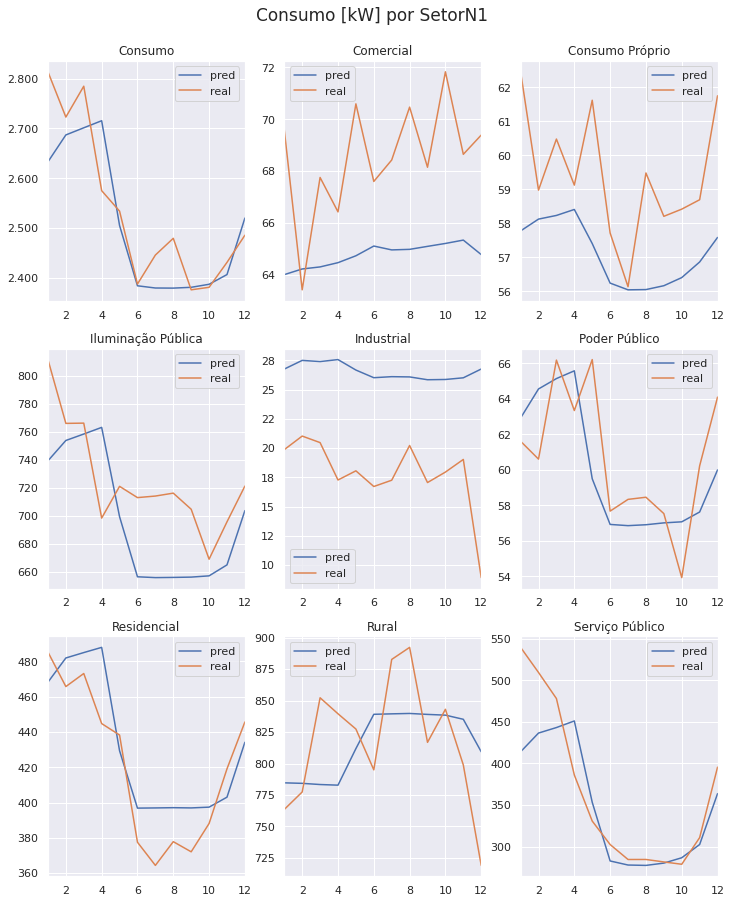

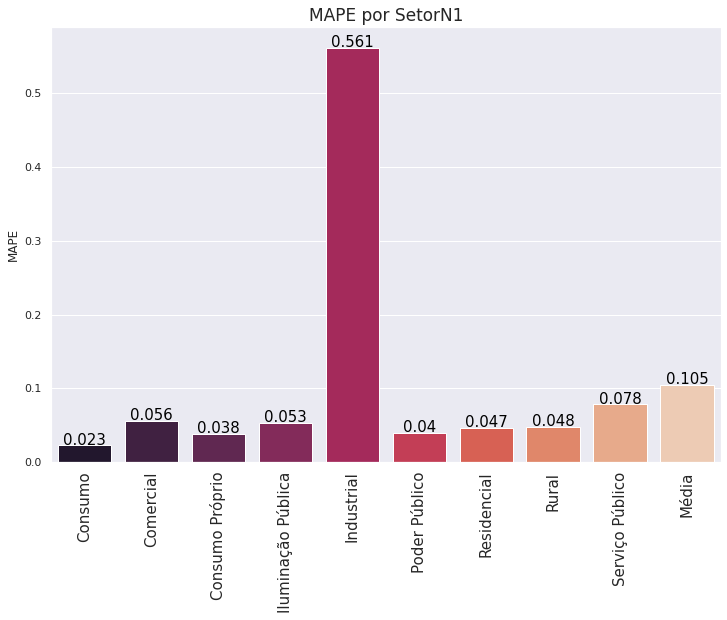

In [35]:
#plt_perfis_de_consumo(yp)

In [ ]:
##
_,_, yp = func_aptidao(np.array(ar_mape_gen))
plt_perfis_de_consumo(yp)

## Relatórios Extras

In [ ]:
plt.figure(figsize=(16,8))
sns.lineplot(range(len(res)),res)
plt.title('MAPE mínimo por Geração', fontsize=17)
plt.ylabel('MAPE')
plt.xlabel('Geração')
plt.show();

In [ ]:
plt.figure(figsize=(16,8))
sns.histplot(arca_mape, kde=True)
plt.title('Distribuíção de erro por genoma', fontsize=17)
#plt.ylabel('MAPE')
#plt.xlabel('Geração')
plt.show();
display(len(arca_mape))

In [ ]:
arca_hist = df_arca_hist(pd.read_csv(urla))
arca_mean = arca_hist.mape.describe()[1]
arca_std = arca_hist.mape.describe()[2]
arca_min = arca_hist.mape.describe()[3]
arca_max =  arca_hist.mape.describe()[7]
arca_hist.mape.describe()

In [ ]:
plt.figure(figsize=(16,8))
sns.histplot(arca_hist.mape, kde=True)

plt.title('Distribuíção de erro por genoma', fontsize=17)
#plt.ylabel('MAPE')
#plt.xlabel('Geração')

xinf = max(arca_mean - 2*arca_std,arca_min)
xsup = min(arca_mean + 2*arca_std,arca_max)
plt.xlim(xinf,xsup)
#plt.xlim(0.0779,0.0829)
plt.show();
display(len(arca_hist.mape))


In [ ]:
arca_hist = df_arca_hist(pd.read_csv(urla))

In [ ]:
plt.figure(figsize=(16,8))

sns.histplot(x = arca_hist.mape, kde=True,palette='Dark2')

plt.title('Distribuíção de erro por genoma', fontsize=17)
#plt.ylabel('MAPE')
#plt.xlabel('Geração')

xinf = max(arca_mean - 2*arca_std,arca_min)
xsup = min(arca_mean + 2*arca_std,arca_max)
plt.xlim(xinf,xsup)
#plt.ylim(0,2000)

plt.show();
display(len(arca_hist.mape),65**4,len(arca_hist.mape)/65**4)
print(xinf, xsup)

In [ ]:
arca_hist.to_excel(path+'genhist.csv')

#Fim